# Processing

In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from typing import List, Optional, Dict

# --- User-Defined Parameters ---

horizons = [1, 5, 10, 22]
EVALUATION_START_DATE = '2010-03-16'
EVALUATION_END_DATE = '2025-01-01'
# EVALUATION_START_DATE = '2008-06-01'
# EVALUATION_END_DATE = '2009-06-01'
ROLLING_WINDOW_SIZE = 1000  # Set to None for expanding window

# --- Data Preparation ---

df = pd.read_csv("merged_RV_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

indices = ['SP500', 'DJ']

for index in indices:
    df[f'RV_daily_{index}'] = df[f'{index}_RV'].shift(1)
    df[f'RV_weekly_{index}'] = df[f'{index}_RV'].rolling(window=5).mean().shift(1)
    df[f'RV_monthly_{index}'] = df[f'{index}_RV'].rolling(window=22).mean().shift(1)
    for h in horizons:
        df[f'Avg_RV_{index}_h{h}'] = df[f'{index}_RV'].rolling(window=h).mean().shift(-h)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Define Evaluation Period ---

start_date = pd.to_datetime(EVALUATION_START_DATE)
end_date = min(pd.to_datetime(EVALUATION_END_DATE), df['Date'].max())
h_max = max(horizons)

df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].iloc[:-h_max].reset_index(drop=True)

# Models

## HAR

In [5]:
# --- Forecasting Function ---

def forecast_har_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices and features
    indices = ['SP500', 'DJ']
    features = {
        index: [f'RV_daily_{index}', f'RV_weekly_{index}', f'RV_monthly_{index}']
        for index in indices
    }
    
    # Prepare the independent variables
    X_all = {
        index: sm.add_constant(df[features[index]])
        for index in indices
    }
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
                
            for index in indices:
                # Get training data
                X_train = X_all[index].iloc[start_idx:i]
                y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                
                # Fit the model
                try:
                    model = sm.OLS(y_train, X_train).fit()
                except Exception as e:
                    print(f"Failed to fit {index} model on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Prepare test data
                X_test = X_all[index].iloc[[i]]
                
                # Make forecast
                try:
                    y_pred = model.predict(X_test).iloc[0]
                except Exception as e:
                    print(f"Failed to predict {index} on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Store forecast and coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': model.params.to_dict()})
                
                # Get true value (average realized volatility)
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
                
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using HAR Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HAR Model ---

# For expanding window
results_har_expanding = forecast_har_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_har_rolling = forecast_har_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)



Expanding Window Size: All Available Data

Average Losses for SP500 using HAR Model:
  1-step ahead forecast - MSE: 0.000000010478, QLIKE: 0.270901207526
  5-step ahead forecast - MSE: 0.000000008299, QLIKE: 0.236528406606
  10-step ahead forecast - MSE: 0.000000007684, QLIKE: 0.252498030864
  22-step ahead forecast - MSE: 0.000000007760, QLIKE: 0.296339849229

Average Losses for DJ using HAR Model:
  1-step ahead forecast - MSE: 0.000000011398, QLIKE: 0.278313826186
  5-step ahead forecast - MSE: 0.000000008665, QLIKE: 0.217878444823
  10-step ahead forecast - MSE: 0.000000008319, QLIKE: 0.227611397739
  22-step ahead forecast - MSE: 0.000000008486, QLIKE: 0.267688117857

Rolling Window Size: 1000

Average Losses for SP500 using HAR Model:
  1-step ahead forecast - MSE: 0.000000010872, QLIKE: 0.288806724164
  5-step ahead forecast - MSE: 0.000000008786, QLIKE: 0.258657718348
  10-step ahead forecast - MSE: 0.000000008045, QLIKE: 0.393797808122
  22-step ahead forecast - MSE: 0.000000

## HARd

In [7]:
# --- Forecasting Function for HARd Model ---

def forecast_hard_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices and features for the HARd model
    indices = ['SP500', 'DJ']
    features = {
        index: [f'RV_daily_{index}']  # Only the daily lagged RV is used in HARd
        for index in indices
    }
    
    # Prepare the independent variables
    X_all = {
        index: sm.add_constant(df[features[index]])
        for index in indices
    }
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
                
            for index in indices:
                # Get training data
                X_train = X_all[index].iloc[start_idx:i]
                y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                
                # Fit the model
                try:
                    model = sm.OLS(y_train, X_train).fit()
                except Exception as e:
                    print(f"Failed to fit {index} model on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Prepare test data
                X_test = X_all[index].iloc[[i]]
                
                # Make forecast
                try:
                    y_pred = model.predict(X_test).iloc[0]
                except Exception as e:
                    print(f"Failed to predict {index} on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Store forecast and coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': model.params.to_dict()})
                
                # Get true value
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
                
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using HARd Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
                
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HARd Model ---

# For expanding window
results_hard_expanding = forecast_hard_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_hard_rolling = forecast_hard_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)



Expanding Window Size: All Available Data

Average Losses for SP500 using HARd Model:
  1-step ahead forecast - MSE: 0.000000010424, QLIKE: 0.353148063238
  5-step ahead forecast - MSE: 0.000000008894, QLIKE: 0.317547728670
  10-step ahead forecast - MSE: 0.000000008146, QLIKE: 0.322232391743
  22-step ahead forecast - MSE: 0.000000008064, QLIKE: 0.344916559415

Average Losses for DJ using HARd Model:
  1-step ahead forecast - MSE: 0.000000011616, QLIKE: 0.353152397543
  5-step ahead forecast - MSE: 0.000000009353, QLIKE: 0.286380527388
  10-step ahead forecast - MSE: 0.000000008848, QLIKE: 0.285712460609
  22-step ahead forecast - MSE: 0.000000008844, QLIKE: 0.304548659947

Rolling Window Size: 1000

Average Losses for SP500 using HARd Model:
  1-step ahead forecast - MSE: 0.000000010936, QLIKE: 0.329081587300
  5-step ahead forecast - MSE: 0.000000009173, QLIKE: 0.310774742774
  10-step ahead forecast - MSE: 0.000000008492, QLIKE: 0.317338169507
  22-step ahead forecast - MSE: 0.000

## HARw

In [9]:
# --- Forecasting Function for HARw Model ---

def forecast_harw_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices and features for the HARw model
    indices = ['SP500', 'DJ']
    features = {
        index: [f'RV_weekly_{index}']  # Only the weekly lagged RV is used in HARw
        for index in indices
    }
    
    # Prepare the independent variables
    X_all = {
        index: sm.add_constant(df[features[index]])
        for index in indices
    }
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
            
            for index in indices:
                # Get training data
                X_train = X_all[index].iloc[start_idx:i]
                y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                
                # Fit the model
                try:
                    model = sm.OLS(y_train, X_train).fit()
                except Exception as e:
                    print(f"Failed to fit {index} model on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Prepare test data
                X_test = X_all[index].iloc[[i]]
                
                # Make forecast
                try:
                    y_pred = model.predict(X_test).iloc[0]
                except Exception as e:
                    print(f"Failed to predict {index} on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Store forecast and coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': model.params.to_dict()})
                
                # Get true value
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using HARw Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HARw Model ---

# For expanding window
results_harw_expanding = forecast_harw_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_harw_rolling = forecast_harw_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)



Expanding Window Size: All Available Data

Average Losses for SP500 using HARw Model:
  1-step ahead forecast - MSE: 0.000000011851, QLIKE: 0.300201363268
  5-step ahead forecast - MSE: 0.000000008797, QLIKE: 0.259796386760
  10-step ahead forecast - MSE: 0.000000007955, QLIKE: 0.272221786772
  22-step ahead forecast - MSE: 0.000000008107, QLIKE: 0.309566885977

Average Losses for DJ using HARw Model:
  1-step ahead forecast - MSE: 0.000000012515, QLIKE: 0.301476980682
  5-step ahead forecast - MSE: 0.000000009165, QLIKE: 0.236535490453
  10-step ahead forecast - MSE: 0.000000008631, QLIKE: 0.241683449814
  22-step ahead forecast - MSE: 0.000000008844, QLIKE: 0.276735667511

Rolling Window Size: 1000

Average Losses for SP500 using HARw Model:
  1-step ahead forecast - MSE: 0.000000012395, QLIKE: 0.318934335192
  5-step ahead forecast - MSE: 0.000000009211, QLIKE: 0.282140226922
  10-step ahead forecast - MSE: 0.000000008273, QLIKE: 0.292760301683
  22-step ahead forecast - MSE: 0.000

## HARm

In [11]:
# --- Forecasting Function for HARm Model ---

def forecast_harm_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices and features for the HARm model
    indices = ['SP500', 'DJ']
    features = {
        index: [f'RV_monthly_{index}']  # Only the monthly lagged RV is used in HARm
        for index in indices
    }
    
    # Prepare the independent variables
    X_all = {
        index: sm.add_constant(df[features[index]])
        for index in indices
    }
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
            
            for index in indices:
                # Get training data
                X_train = X_all[index].iloc[start_idx:i]
                y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                
                # Fit the model
                try:
                    model = sm.OLS(y_train, X_train).fit()
                except Exception as e:
                    print(f"Failed to fit {index} model on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Prepare test data
                X_test = X_all[index].iloc[[i]]
                
                # Make forecast
                try:
                    y_pred = model.predict(X_test).iloc[0]
                except Exception as e:
                    print(f"Failed to predict {index} on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Store forecast and coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': model.params.to_dict()})
                
                # Get true value
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using HARm Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HARm Model ---

# For expanding window
results_harm_expanding = forecast_harm_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_harm_rolling = forecast_harm_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)



Expanding Window Size: All Available Data

Average Losses for SP500 using HARm Model:
  1-step ahead forecast - MSE: 0.000000015335, QLIKE: 0.366029650694
  5-step ahead forecast - MSE: 0.000000011384, QLIKE: 0.304443767834
  10-step ahead forecast - MSE: 0.000000010185, QLIKE: 0.303325216321
  22-step ahead forecast - MSE: 0.000000008737, QLIKE: 0.325342365666

Average Losses for DJ using HARm Model:
  1-step ahead forecast - MSE: 0.000000016485, QLIKE: 0.361632026074
  5-step ahead forecast - MSE: 0.000000012125, QLIKE: 0.278988115652
  10-step ahead forecast - MSE: 0.000000011040, QLIKE: 0.276037372714
  22-step ahead forecast - MSE: 0.000000009641, QLIKE: 0.296140807589

Rolling Window Size: 1000

Average Losses for SP500 using HARm Model:
  1-step ahead forecast - MSE: 0.000000015896, QLIKE: 0.381789425758
  5-step ahead forecast - MSE: 0.000000011574, QLIKE: 0.323412627475
  10-step ahead forecast - MSE: 0.000000010022, QLIKE: 0.325503633927
  22-step ahead forecast - MSE: 0.000

## Daily Lag

In [13]:
# --- Forecasting Function for Daily Lag Naive Model ---

def forecast_daily_lag_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices
    indices = ['SP500', 'DJ']
    
    # Dictionaries to store forecasts and (placeholder) coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}  # Not applicable for naive forecasts
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
            
            for index in indices:
                # Ensure there is a previous observation within the training window
                if i - 1 < start_idx:
                    continue  # Not enough data to make a forecast
                
                # Daily lag forecast: use the last observed daily lag value
                y_pred = df.iloc[i - 1][f'RV_daily_{index}']
                
                # Store forecast and placeholder coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': None})
                
                # Get true value (average realized volatility)
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using Daily Lag Naive Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the Daily Lag Naive Forecasting Model ---

# For expanding window
results_daily_lag_expanding = forecast_daily_lag_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_daily_lag_rolling = forecast_daily_lag_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)



Expanding Window Size: All Available Data

Average Losses for SP500 using Daily Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000015695, QLIKE: 0.436869100946
  5-step ahead forecast - MSE: 0.000000014714, QLIKE: 0.463351342679
  10-step ahead forecast - MSE: 0.000000014389, QLIKE: 0.540519755972
  22-step ahead forecast - MSE: 0.000000016980, QLIKE: 0.741007403836

Average Losses for DJ using Daily Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000017083, QLIKE: 0.453419479465
  5-step ahead forecast - MSE: 0.000000015425, QLIKE: 0.459643835939
  10-step ahead forecast - MSE: 0.000000015509, QLIKE: 0.523579350586
  22-step ahead forecast - MSE: 0.000000018152, QLIKE: 0.704257696527

Rolling Window Size: 1000

Average Losses for SP500 using Daily Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000015695, QLIKE: 0.436869100946
  5-step ahead forecast - MSE: 0.000000014714, QLIKE: 0.463351342679
  10-step ahead forecast - MSE: 0.000000014389, QLIKE: 0.540519755972
  22

## Weekly Lag

In [15]:
# --- Forecasting Function for Weekly Lag Naive Model ---

def forecast_weekly_lag_model(df, df_evaluation, horizons, rolling_window_size=None):
    # Define indices
    indices = ['SP500', 'DJ']
    
    # Dictionaries to store forecasts and (placeholder) coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}  # Not applicable for naive forecasts
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
            
            for index in indices:
                # Ensure there is a previous observation within the training window
                if i - 1 < start_idx:
                    continue  # Not enough data to make a forecast
                
                # Weekly lag forecast: use the last observed weekly lag value
                y_pred = df.iloc[i - 1][f'RV_weekly_{index}']
                
                # Store forecast and placeholder coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': None})
                
                # Get true value (average realized volatility)
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using Weekly Lag Naive Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the Weekly Lag Naive Forecasting Model ---

# For expanding window
results_weekly_lag_expanding = forecast_weekly_lag_model(df.copy(), df_evaluation, horizons, rolling_window_size=None)

# For rolling window (e.g., 1000 days)
results_weekly_lag_rolling = forecast_weekly_lag_model(df.copy(), df_evaluation, horizons, rolling_window_size=ROLLING_WINDOW_SIZE)


Expanding Window Size: All Available Data

Average Losses for SP500 using Weekly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000014714, QLIKE: 0.358754407050
  5-step ahead forecast - MSE: 0.000000011380, QLIKE: 0.333068793757
  10-step ahead forecast - MSE: 0.000000011244, QLIKE: 0.381579188125
  22-step ahead forecast - MSE: 0.000000013232, QLIKE: 0.532832661379

Average Losses for DJ using Weekly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000015426, QLIKE: 0.354846869234
  5-step ahead forecast - MSE: 0.000000011878, QLIKE: 0.304205548482
  10-step ahead forecast - MSE: 0.000000012039, QLIKE: 0.341691359391
  22-step ahead forecast - MSE: 0.000000014030, QLIKE: 0.477282986603

Rolling Window Size: 1000

Average Losses for SP500 using Weekly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000014714, QLIKE: 0.358754407050
  5-step ahead forecast - MSE: 0.000000011380, QLIKE: 0.333068793757
  10-step ahead forecast - MSE: 0.000000011244, QLIKE: 0.381579188125
 

## Monthly Lag

In [17]:
# --- Forecasting Function for Monthly Lag Naive Model ---

def forecast_monthly_lag_naive_model(df, df_evaluation, horizons, rolling_window_size=None):
    import numpy as np

    # Define indices (e.g., 'SP500' and 'DJ')
    indices = ['SP500', 'DJ']
    
    # Dictionaries to store forecasts and (placeholder) coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}  # Not used in naive forecasts
    
    # Initialize variables to accumulate MSEs, QLIKEs, and forecast counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Loop over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        # Find the corresponding index in the full DataFrame
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        
        for h in horizons:
            # Ensure there is enough data ahead for an h-step forecast
            if i + h >= len(df):
                continue
            
            # Define the training window (for consistency with other models)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0
            
            for index in indices:
                # Make sure there's at least one previous observation
                if i - 1 < start_idx:
                    continue  # Not enough data to make a forecast
                
                # Naive forecast: use the last observed monthly lagged RV
                # Math: y_pred = RV_monthly_{index} at time (t-1)
                y_pred = df.iloc[i - 1][f'RV_monthly_{index}']
                
                # Store forecast and placeholder coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': None})
                
                # Compute the true value:
                # Math: y_true_avg = (1/h) * sum_{j=1}^{h} RV_{t+j}
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()
                
                # Calculate the Mean Squared Error (MSE)
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE loss (if both y_pred and y_true_avg are positive)
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate the error metrics and increment the forecast count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    for index in indices:
        print(f"\nAverage Losses for {index} using Monthly Lag Naive Model:")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f"  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}")
            else:
                print(f"  {h}-step ahead forecast - No data available.")
    
    # Return forecasts, coefficients, and loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the Monthly Lag Naive Forecasting Model ---

# For expanding window (using all available data for training)
results_monthly_lag_naive_expanding = forecast_monthly_lag_naive_model(
    df.copy(),
    df_evaluation,
    horizons,                    # e.g., horizons = [1, 5, 10, 22]
    rolling_window_size=None
)

# For rolling window (e.g., last 1000 days)
results_monthly_lag_naive_rolling = forecast_monthly_lag_naive_model(
    df.copy(),
    df_evaluation,
    horizons,
    rolling_window_size=ROLLING_WINDOW_SIZE  # e.g., ROLLING_WINDOW_SIZE = 1000
)



Expanding Window Size: All Available Data

Average Losses for SP500 using Monthly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000016970, QLIKE: 0.410137794443
  5-step ahead forecast - MSE: 0.000000013222, QLIKE: 0.364165930547
  10-step ahead forecast - MSE: 0.000000012430, QLIKE: 0.389055684648
  22-step ahead forecast - MSE: 0.000000011878, QLIKE: 0.475649531830

Average Losses for DJ using Monthly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000018149, QLIKE: 0.401087936602
  5-step ahead forecast - MSE: 0.000000014026, QLIKE: 0.332557847903
  10-step ahead forecast - MSE: 0.000000013364, QLIKE: 0.351060552690
  22-step ahead forecast - MSE: 0.000000012963, QLIKE: 0.427681574471

Rolling Window Size: 1000

Average Losses for SP500 using Monthly Lag Naive Model:
  1-step ahead forecast - MSE: 0.000000016970, QLIKE: 0.410137794443
  5-step ahead forecast - MSE: 0.000000013222, QLIKE: 0.364165930547
  10-step ahead forecast - MSE: 0.000000012430, QLIKE: 0.38905568464

## HARew

In [19]:
# --- Forecasting Function for HARew Model (No Intercept) with Evaluation Period ---

def forecast_harew_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    # Define indices and features for the HARew model
    indices = ['SP500', 'DJ']
    features = {
        index: [f'RV_daily_{index}', f'RV_weekly_{index}', f'RV_monthly_{index}']  # Using daily, weekly, and monthly lagged RVs
        for index in indices
    }
    
    # Prepare the independent variables without adding a constant (no intercept)
    X_all = {
        index: df[features[index]]
        for index in indices
    }
    
    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()
    
    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0  # Expanding window
            
            for index in indices:
                # Get training data
                X_train = X_all[index].iloc[start_idx:i]
                y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                
                # Ensure matching lengths
                if len(y_train) != X_train.shape[0]:
                    continue
                
                # Fit the model without intercept
                try:
                    model = sm.OLS(y_train, X_train).fit()
                except Exception as e:
                    print(f"Failed to fit {index} model on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Prepare test data
                X_test = X_all[index].iloc[[i]]
                
                # Make forecast
                try:
                    y_pred = model.predict(X_test).iloc[0]
                except Exception as e:
                    print(f"Failed to predict {index} on {current_date.date()} for horizon {h}: {e}")
                    continue
                
                # Store forecast and model coefficients
                forecasts[index][h].append({'date': current_date, 'forecast': y_pred})
                coefficients[index][h].append({'date': current_date, 'coefficients': model.params.to_dict()})
                
                # Get true value
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for HARew Model (No Intercept):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HARew Model ---

# For expanding window
results_harew_expanding = forecast_harew_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_harew_rolling = forecast_harew_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)


Expanding Window Size: All Available Data

Average Losses for HARew Model (No Intercept):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010532, QLIKE: 0.286800232839
  5-step ahead forecast - MSE: 0.000000008469, QLIKE: 0.288145243189
  10-step ahead forecast - MSE: 0.000000007977, QLIKE: 0.361856204294
  22-step ahead forecast - MSE: 0.000000008338, QLIKE: 0.584001488478

Index: DJ
  1-step ahead forecast - MSE: 0.000000011451, QLIKE: 0.292313471581
  5-step ahead forecast - MSE: 0.000000008843, QLIKE: 0.259524843983
  10-step ahead forecast - MSE: 0.000000008647, QLIKE: 0.315100390093
  22-step ahead forecast - MSE: 0.000000009176, QLIKE: 0.508572318944

Rolling Window Size: 1000

Average Losses for HARew Model (No Intercept):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010879, QLIKE: 0.328355567938
  5-step ahead forecast - MSE: 0.000000008977, QLIKE: 0.369895540585
  10-step ahead forecast - MSE: 0.000000008431, QLIKE: 0.515031473068
  22-step ahead forecast - MSE:

## iHARew

In [21]:
# --- Forecasting Function for iHARew Model with Evaluation Period ---

def forecast_iHARew_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    # Define indices
    indices = ['SP500', 'DJ']
    
    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()
    
    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)
    
    # Initialize variables to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: 0.0 for h in horizons} for index in indices}
    qlike = {index: {h: 0.0 for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}
    
    # Prepare independent variables for each model
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }
    
    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    
    # Iterate over each row in the evaluation period
    for idx, row in df_evaluation.iterrows():
        current_date = row['Date']
        i_list = df.index[df['Date'] == current_date].tolist()
        if not i_list:
            continue
        i = i_list[0]
        
        for h in horizons:
            if i + h >= len(df):
                continue
            
            # Define training window
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0  # Expanding window
            
            for index in indices:
                individual_forecasts = {}
                individual_coeffs = {}
                combined_forecasts = []
                model_names = ['HARd', 'HARw', 'HARm']
                
                for model_name in model_names:
                    # Get training data
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    
                    # Ensure matching lengths
                    if len(y_train) != X_train.shape[0]:
                        continue
                    
                    # Fit the model
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} model on {current_date.date()} for horizon {h}: {e}")
                        continue
                    
                    # Prepare test data
                    X_test = X_all[index][model_name].iloc[[i]]
                    
                    # Make forecast
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        combined_forecasts.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                
                # Combine forecasts if any are available
                if combined_forecasts:
                    y_pred_combined = np.mean(combined_forecasts)
                else:
                    continue  # Skip if no forecasts are available
                
                # Store the combined forecast along with individual model details
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual': individual_forecasts
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual': individual_coeffs
                })
                
                # Get true value (average realized volatility)
                y_true_avg = df.iloc[i+1:i + h + 1][f'{index}_RV'].mean()
                
                # Calculate MSE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                
                # Calculate QLIKE with safety check
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan
                
                # Accumulate losses and count
                mse[index][h] += mse_value
                if not np.isnan(qlike_value):
                    qlike[index][h] += qlike_value
                count[index][h] += 1
    
    # --- Compute and Print Average MSEs and QLIKEs ---
    
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHARew Model:")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if count[index][h] > 0:
                avg_mse = mse[index][h] / count[index][h]
                avg_qlike = qlike[index][h] / count[index][h]
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')
    
    # Return stored forecasts and coefficients along with loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the iHARew Model ---

# For expanding window
results_iHARew_expanding = forecast_iHARew_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_iHARew_rolling = forecast_iHARew_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHARew Model:

Index: SP500
  1-step ahead forecast - MSE: 0.000000010817, QLIKE: 0.319168668868
  5-step ahead forecast - MSE: 0.000000008231, QLIKE: 0.277465252868
  10-step ahead forecast - MSE: 0.000000007491, QLIKE: 0.284595906669
  22-step ahead forecast - MSE: 0.000000007370, QLIKE: 0.316796151047

Index: DJ
  1-step ahead forecast - MSE: 0.000000011655, QLIKE: 0.316167482637
  5-step ahead forecast - MSE: 0.000000008570, QLIKE: 0.248915296744
  10-step ahead forecast - MSE: 0.000000008051, QLIKE: 0.251223342925
  22-step ahead forecast - MSE: 0.000000008005, QLIKE: 0.281293880868

Rolling Window Size: 1000

Average Losses for iHARew Model:

Index: SP500
  1-step ahead forecast - MSE: 0.000000011276, QLIKE: 0.322368923435
  5-step ahead forecast - MSE: 0.000000008608, QLIKE: 0.289616866398
  10-step ahead forecast - MSE: 0.000000007681, QLIKE: 0.297581476479
  22-step ahead forecast - MSE: 0.000000007289, QLIKE: 0.33

## HAR OW1

In [23]:
# --- Forecasting Function for HAR OW1 with Evaluation Period ---

def forecast_HAR_OW1_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}

    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # For each horizon, calculate unconditionally optimal weights using in-sample data (before the evaluation period)
    weights_dict = {}
    for h in horizons:
        weights_dict[h] = {}
        in_sample_data = df[df['Date'] < start_date]
        if in_sample_data.empty:
            print(f"No in-sample data available before {start_date.date()} for horizon {h}.")
            continue
        for index in indices:
            model_names = ['HARd', 'HARw', 'HARm']
            residuals = []
            for model_name in model_names:
                X_in_sample = X_all[index][model_name][df['Date'] < start_date]
                y_in_sample = in_sample_data[f'Avg_RV_{index}_h{h}']
                try:
                    model = sm.OLS(y_in_sample, X_in_sample).fit()
                except Exception as e:
                    print(f"Failed to fit {index} {model_name} on in-sample data for horizon {h}: {e}")
                    continue
                residuals.append(model.resid.values)
            # Check if we have residuals from all three models
            if len(residuals) < 3:
                continue
            residuals_matrix = np.vstack(residuals).T
            if residuals_matrix.shape[0] < 2:
                continue  # Not enough observations for covariance estimation
            Sigma_e = np.cov(residuals_matrix, rowvar=False)
            ones = np.ones(len(model_names))
            try:
                inv_Sigma_e = np.linalg.inv(Sigma_e)
                w_opt = inv_Sigma_e @ ones / (ones.T @ inv_Sigma_e @ ones)
            except np.linalg.LinAlgError:
                w_opt = ones / len(model_names)
            weights_dict[h][index] = w_opt
            print(f"Optimal Weights for {index} at horizon {h}: {w_opt}")

    # Iterate over each horizon and each observation in the evaluation period
    for h in horizons:
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                # Ensure weights for this horizon and index exist
                if h not in weights_dict or index not in weights_dict[h]:
                    continue

                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                individual_forecasts = {}
                individual_coeffs = {}

                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    if len(y_train) != X_train.shape[0]:
                        continue
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                # Skip if forecasts from all three models are not available
                if len(forecasts_list) < 3:
                    continue

                # Combine forecasts using the unconditionally optimal weights
                w_opt = weights_dict[h][index]
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # Store combined forecast, individual forecasts, and weights
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs
                })

                # Get the true value over the horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Compute MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                mse[index][h].append(mse_value)
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                    if not np.isnan(qlike_value):
                        qlike[index][h].append(qlike_value)
                count[index][h] += 1

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHARew Model with Unconditionally Optimal Weights:")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h]) if qlike[index][h] else np.nan
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return the forecasts, coefficients, loss metrics, counts, and weights
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count,
        'weights': weights_dict
    }

# --- Run the HAR_OW1 Model ---

# For expanding window
results_HAR_OW1_expanding = forecast_HAR_OW1_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW1_rolling = forecast_HAR_OW1_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)

Optimal Weights for SP500 at horizon 1: [0.28503233 0.63106965 0.08389802]
Optimal Weights for DJ at horizon 1: [0.23662704 0.6354097  0.12796326]
Optimal Weights for SP500 at horizon 5: [0.23192106 0.58566192 0.18241703]
Optimal Weights for DJ at horizon 5: [0.21663687 0.56301714 0.22034599]
Optimal Weights for SP500 at horizon 10: [0.18684777 0.56623191 0.24692032]
Optimal Weights for DJ at horizon 10: [0.16023918 0.5915311  0.24822972]
Optimal Weights for SP500 at horizon 22: [0.14295079 0.63701218 0.22003703]
Optimal Weights for DJ at horizon 22: [0.14373969 0.68655615 0.16970416]

Expanding Window Size: All Available Data

Average Losses for iHARew Model with Unconditionally Optimal Weights:

Index: SP500
  1-step ahead forecast - MSE: 0.000000010675, QLIKE: 0.309334560807
  5-step ahead forecast - MSE: 0.000000008194, QLIKE: 0.269869027231
  10-step ahead forecast - MSE: 0.000000007526, QLIKE: 0.278243037875
  22-step ahead forecast - MSE: 0.000000007578, QLIKE: 0.311707125739

I

### HAR OW1 (Non-negative forecasts)

In [25]:
def forecast_HAR_OW1_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries to accumulate MSEs, QLIKEs, and counts
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}

    # Dictionaries to store forecasts and coefficients
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # For each horizon, calculate unconditionally optimal weights using in-sample data (before the evaluation period)
    weights_dict = {}
    for h in horizons:
        weights_dict[h] = {}
        in_sample_data = df[df['Date'] < start_date]
        if in_sample_data.empty:
            print(f"No in-sample data available before {start_date.date()} for horizon {h}.")
            continue
        for index in indices:
            model_names = ['HARd', 'HARw', 'HARm']
            residuals = []
            for model_name in model_names:
                X_in_sample = X_all[index][model_name][df['Date'] < start_date]
                y_in_sample = in_sample_data[f'Avg_RV_{index}_h{h}']
                try:
                    model = sm.OLS(y_in_sample, X_in_sample).fit()
                except Exception as e:
                    print(f"Failed to fit {index} {model_name} on in-sample data for horizon {h}: {e}")
                    continue
                residuals.append(model.resid.values)
            # Check if we have residuals from all three models
            if len(residuals) < 3:
                continue
            residuals_matrix = np.vstack(residuals).T
            if residuals_matrix.shape[0] < 2:
                continue  # Not enough observations for covariance estimation
            Sigma_e = np.cov(residuals_matrix, rowvar=False)
            ones = np.ones(len(model_names))
            try:
                inv_Sigma_e = np.linalg.inv(Sigma_e)
                w_opt = inv_Sigma_e @ ones / (ones.T @ inv_Sigma_e @ ones)
            except np.linalg.LinAlgError:
                w_opt = ones / len(model_names)
            weights_dict[h][index] = w_opt
            print(f"Optimal Weights for {index} at horizon {h}: {w_opt}")

    # Iterate over each horizon and each observation in the evaluation period
    for h in horizons:
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                # Ensure weights for this horizon and index exist
                if h not in weights_dict or index not in weights_dict[h]:
                    continue

                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                individual_forecasts = {}
                individual_coeffs = {}

                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    if len(y_train) != X_train.shape[0]:
                        continue
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                # Skip if forecasts from all three models are not available
                if len(forecasts_list) < 3:
                    continue

                # Combine forecasts using the unconditionally optimal weights
                w_opt = weights_dict[h][index]
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # --- Ensure non-negative forecasts ---
                if y_pred_combined < 0:
                    # Look for the last positive combined forecast for the same index and horizon
                    last_positive = None
                    for past_forecast in reversed(forecasts[index][h]):
                        if past_forecast['combined_forecast'] > 0:
                            last_positive = past_forecast['combined_forecast']
                            break
                    if last_positive is not None:
                        y_pred_combined = last_positive
                    else:
                        y_pred_combined = 0.0

                # Store combined forecast, individual forecasts, and weights
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs
                })

                # Get the true value over the horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Compute MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                mse[index][h].append(mse_value)
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                    if not np.isnan(qlike_value):
                        qlike[index][h].append(qlike_value)
                count[index][h] += 1

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHARew Model with Unconditionally Optimal Weights:")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h]) if qlike[index][h] else np.nan
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return the forecasts, coefficients, loss metrics, counts, and weights
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count,
        'weights': weights_dict
    }

# --- Run the HAR_OW1 Model ---

# For expanding window
results_HAR_OW1_expanding = forecast_HAR_OW1_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW1_rolling = forecast_HAR_OW1_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)


Optimal Weights for SP500 at horizon 1: [0.28503233 0.63106965 0.08389802]
Optimal Weights for DJ at horizon 1: [0.23662704 0.6354097  0.12796326]
Optimal Weights for SP500 at horizon 5: [0.23192106 0.58566192 0.18241703]
Optimal Weights for DJ at horizon 5: [0.21663687 0.56301714 0.22034599]
Optimal Weights for SP500 at horizon 10: [0.18684777 0.56623191 0.24692032]
Optimal Weights for DJ at horizon 10: [0.16023918 0.5915311  0.24822972]
Optimal Weights for SP500 at horizon 22: [0.14295079 0.63701218 0.22003703]
Optimal Weights for DJ at horizon 22: [0.14373969 0.68655615 0.16970416]

Expanding Window Size: All Available Data

Average Losses for iHARew Model with Unconditionally Optimal Weights:

Index: SP500
  1-step ahead forecast - MSE: 0.000000010675, QLIKE: 0.309334560807
  5-step ahead forecast - MSE: 0.000000008194, QLIKE: 0.269869027231
  10-step ahead forecast - MSE: 0.000000007526, QLIKE: 0.278243037875
  22-step ahead forecast - MSE: 0.000000007578, QLIKE: 0.311707125739

I

## HAR OW2

In [27]:
# --- Forecasting Function for HAR OW2 with Evaluation Period ---

def forecast_HAR_OW2_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries for loss metrics (using lists for each observation)
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}

    # Dictionaries to store forecasts, individual coefficients, and optimal weights
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # Iterate over each forecast horizon
    for h in horizons:
        # Iterate over each observation in the evaluation period
        for _, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0  # Expanding window

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                residuals_list = []
                individual_forecasts = {}
                individual_coeffs = {}

                # Fit each HAR variant and collect forecasts and residuals
                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    
                    # Check for sufficient training data
                    if X_train.empty or len(y_train) != X_train.shape[0]:
                        continue

                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} model on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Collect residuals for weight calculation
                    residuals_list.append(model.resid.values)

                    # Prepare test data and forecast
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                # Skip if not all models were successfully fitted
                if len(forecasts_list) < 3 or len(residuals_list) < 3:
                    continue

                # Stack residuals and compute covariance matrix
                residuals_matrix = np.vstack(residuals_list).T
                if residuals_matrix.shape[0] < 2:
                    continue  # Not enough observations for covariance estimation

                Sigma = np.cov(residuals_matrix, rowvar=False)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma = np.linalg.inv(Sigma)
                    w_opt = inv_Sigma @ ones / (ones.T @ inv_Sigma @ ones)
                except np.linalg.LinAlgError:
                    w_opt = ones / len(model_names)  # Fallback to equal weights

                # Combine forecasts using the optimal weights
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # Store the combined forecast, individual forecasts, and optimal weights
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs
                })

                # Get true value over the horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Compute MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                mse[index][h].append(mse_value)
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                    if not np.isnan(qlike_value):
                        qlike[index][h].append(qlike_value)
                count[index][h] += 1

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR_cow Model (HAR_OW2):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h]) if qlike[index][h] else np.nan
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return forecasts, coefficients, and loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HAR_OW2 Model ---

# For expanding window
results_HAR_OW2_expanding = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW2_rolling = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)


Expanding Window Size: All Available Data

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010538, QLIKE: 0.311135474419
  5-step ahead forecast - MSE: 0.000000008186, QLIKE: 0.270260972670
  10-step ahead forecast - MSE: 0.000000007523, QLIKE: 0.278533536443
  22-step ahead forecast - MSE: 0.000000007554, QLIKE: 0.312332352089

Index: DJ
  1-step ahead forecast - MSE: 0.000000011425, QLIKE: 0.308118321198
  5-step ahead forecast - MSE: 0.000000008522, QLIKE: 0.242967830427
  10-step ahead forecast - MSE: 0.000000008122, QLIKE: 0.245500949744
  22-step ahead forecast - MSE: 0.000000008244, QLIKE: 0.277831974587

Rolling Window Size: 1000

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010820, QLIKE: 0.320713672552
  5-step ahead forecast - MSE: 0.000000008571, QLIKE: 0.285729899783
  10-step ahead forecast - MSE: 0.000000008183, QLIKE: 0.293807145521
  22-step ahead forecast - MSE: 0.0

### HAR OW2 (Non-negative forecasts)

In [29]:
def forecast_HAR_OW2_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries for loss metrics (using lists for each observation)
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}

    # Dictionaries to store forecasts, individual coefficients, and optimal weights
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # Iterate over each forecast horizon
    for h in horizons:
        # Iterate over each observation in the evaluation period
        for _, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0  # Expanding window

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                residuals_list = []
                individual_forecasts = {}
                individual_coeffs = {}

                # Fit each HAR variant and collect forecasts and residuals
                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    
                    # Check for sufficient training data
                    if X_train.empty or len(y_train) != X_train.shape[0]:
                        continue

                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} model on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Collect residuals for weight calculation
                    residuals_list.append(model.resid.values)

                    # Prepare test data and forecast
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                # Skip if not all models were successfully fitted
                if len(forecasts_list) < 3 or len(residuals_list) < 3:
                    continue

                # Stack residuals and compute covariance matrix
                residuals_matrix = np.vstack(residuals_list).T
                if residuals_matrix.shape[0] < 2:
                    continue  # Not enough observations for covariance estimation

                Sigma = np.cov(residuals_matrix, rowvar=False)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma = np.linalg.inv(Sigma)
                    w_opt = inv_Sigma @ ones / (ones.T @ inv_Sigma @ ones)
                except np.linalg.LinAlgError:
                    w_opt = ones / len(model_names)  # Fallback to equal weights

                # Combine forecasts using the optimal weights
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # --- Ensure non-negative forecasts ---
                if y_pred_combined < 0:
                    # Look for the last positive combined forecast for the same index and horizon
                    last_positive = None
                    for past_forecast in reversed(forecasts[index][h]):
                        if past_forecast['combined_forecast'] > 0:
                            last_positive = past_forecast['combined_forecast']
                            break
                    if last_positive is not None:
                        y_pred_combined = last_positive
                    else:
                        y_pred_combined = 0.0

                # Store the combined forecast, individual forecasts, and optimal weights.
                # Here we now also store the model weights under 'model_weights'
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs,
                    'model_weights': dict(zip(model_names, w_opt.tolist()))
                })

                # Get true value over the horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Compute MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                mse[index][h].append(mse_value)
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                    if not np.isnan(qlike_value):
                        qlike[index][h].append(qlike_value)
                count[index][h] += 1

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR_cow Model (HAR_OW2):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h]) if qlike[index][h] else np.nan
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return forecasts, coefficients (with stored model weights), loss metrics, and counts
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HAR_OW2 Model ---

# For expanding window
results_HAR_OW2_expanding = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW2_rolling = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010538, QLIKE: 0.311135474419
  5-step ahead forecast - MSE: 0.000000008186, QLIKE: 0.270260972670
  10-step ahead forecast - MSE: 0.000000007523, QLIKE: 0.278533536443
  22-step ahead forecast - MSE: 0.000000007554, QLIKE: 0.312332352089

Index: DJ
  1-step ahead forecast - MSE: 0.000000011425, QLIKE: 0.308118321198
  5-step ahead forecast - MSE: 0.000000008522, QLIKE: 0.242967830427
  10-step ahead forecast - MSE: 0.000000008122, QLIKE: 0.245500949744
  22-step ahead forecast - MSE: 0.000000008244, QLIKE: 0.277831974587

Rolling Window Size: 1000

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010820, QLIKE: 0.320713672552
  5-step ahead forecast - MSE: 0.000000008571, QLIKE: 0.285729899783
  10-step ahead forecast - MSE: 0.000000008183, QLIKE: 0.293807145521
  22-step ahead forecast - MSE: 0.0

In [30]:
def forecast_HAR_OW2_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries for loss metrics (using lists for each observation)
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}
    count = {index: {h: 0 for h in horizons} for index in indices}

    # Dictionaries to store forecasts, individual coefficients, and optimal weights
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # Iterate over each forecast horizon
    for h in horizons:
        # Iterate over each observation in the evaluation period
        for _, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0  # Expanding window

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                residuals_list = []
                individual_forecasts = {}
                individual_coeffs = {}

                # Fit each HAR variant and collect forecasts and residuals
                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    
                    # Check for sufficient training data
                    if X_train.empty or len(y_train) != X_train.shape[0]:
                        continue

                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} model on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Collect residuals for weight calculation
                    residuals_list.append(model.resid.values)

                    # Prepare test data and forecast
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                # Skip if not all models were successfully fitted
                if len(forecasts_list) < 3 or len(residuals_list) < 3:
                    continue

                # Stack residuals and compute covariance matrix
                residuals_matrix = np.vstack(residuals_list).T
                if residuals_matrix.shape[0] < 2:
                    continue  # Not enough observations for covariance estimation

                Sigma = np.cov(residuals_matrix, rowvar=False)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma = np.linalg.inv(Sigma)
                    w_opt = inv_Sigma @ ones / (ones.T @ inv_Sigma @ ones)
                except np.linalg.LinAlgError:
                    w_opt = ones / len(model_names)  # Fallback to equal weights

                # Combine forecasts using the optimal weights
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # --- Ensure non-negative forecasts ---
                if y_pred_combined < 0:
                    # Look for the last positive combined forecast for the same index and horizon
                    last_positive = None
                    for past_forecast in reversed(forecasts[index][h]):
                        if past_forecast['combined_forecast'] > 0:
                            last_positive = past_forecast['combined_forecast']
                            break
                    if last_positive is not None:
                        y_pred_combined = last_positive
                    else:
                        y_pred_combined = 0.0

                # Store the combined forecast, individual forecasts, and optimal weights
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs
                })

                # Get true value over the horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Compute MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                mse[index][h].append(mse_value)
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                    if not np.isnan(qlike_value):
                        qlike[index][h].append(qlike_value)
                count[index][h] += 1

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR_cow Model (HAR_OW2):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h]) if qlike[index][h] else np.nan
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return forecasts, coefficients, and loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'counts': count
    }

# --- Run the HAR_OW2 Model ---

# For expanding window
results_HAR_OW2_expanding = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW2_rolling = forecast_HAR_OW2_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010538, QLIKE: 0.311135474419
  5-step ahead forecast - MSE: 0.000000008186, QLIKE: 0.270260972670
  10-step ahead forecast - MSE: 0.000000007523, QLIKE: 0.278533536443
  22-step ahead forecast - MSE: 0.000000007554, QLIKE: 0.312332352089

Index: DJ
  1-step ahead forecast - MSE: 0.000000011425, QLIKE: 0.308118321198
  5-step ahead forecast - MSE: 0.000000008522, QLIKE: 0.242967830427
  10-step ahead forecast - MSE: 0.000000008122, QLIKE: 0.245500949744
  22-step ahead forecast - MSE: 0.000000008244, QLIKE: 0.277831974587

Rolling Window Size: 1000

Average Losses for iHAR_cow Model (HAR_OW2):

Index: SP500
  1-step ahead forecast - MSE: 0.000000010820, QLIKE: 0.320713672552
  5-step ahead forecast - MSE: 0.000000008571, QLIKE: 0.285729899783
  10-step ahead forecast - MSE: 0.000000008183, QLIKE: 0.293807145521
  22-step ahead forecast - MSE: 0.0

## HAR OW3

In [32]:
# --- Forecasting Function for HAR OW3 with Evaluation Period ---

def forecast_HAR_OW3_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries for loss metrics
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}

    # Dictionaries to store forecasts, coefficients, optimal weights, and AR(1) parameters
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    optimal_weights = {index: {h: [] for h in horizons} for index in indices}
    ar1_params = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # Helper function to fit AR(1) without intercept
    def fit_ar1(residuals):
        if len(residuals) < 2:
            return 0.0
        e_t = residuals[1:]
        e_tm1 = residuals[:-1]
        model_ar1 = sm.OLS(e_t, e_tm1).fit()
        phi = model_ar1.params[0]
        return phi

    # Iterate over each forecast horizon and evaluation observation
    for h in horizons:
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                residuals_list = []
                phi_values = []
                e_T_values = []
                individual_forecasts = {}
                individual_coeffs = {}

                for model_name in model_names:
                    # Get training data
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    if len(y_train) != X_train.shape[0]:
                        continue

                    # Fit the model
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                        # Store residuals for later weight adjustment
                        residuals_list.append(model.resid.values)
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Prepare test data and forecast
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Fit AR(1) to residuals and get latest residual
                    phi = fit_ar1(model.resid.values)
                    phi_values.append(phi)
                    e_T = model.resid.values[-1]
                    e_T_values.append(e_T)

                # Ensure forecasts and residuals from all three models are available
                if len(forecasts_list) < 3 or len(residuals_list) < 3:
                    continue

                # Compute covariance matrix of residuals
                residuals_matrix = np.vstack(residuals_list).T
                Sigma_e = np.cov(residuals_matrix, rowvar=False)

                # Compute b_T = phi * e_T for each model
                b_T = np.array([phi_values[j] * e_T_values[j] for j in range(len(phi_values))])

                # Adjust Sigma by adding outer product of b_T
                Sigma_plus_bt = Sigma_e + np.outer(b_T, b_T)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma_plus_bt = np.linalg.inv(Sigma_plus_bt)
                    w_opt = inv_Sigma_plus_bt @ ones / (ones.T @ inv_Sigma_plus_bt @ ones)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for {index} on {current_date.date()} with horizon {h}. Using equal weights.")
                    w_opt = ones / len(model_names)

                # Combine forecasts using the computed weights
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # Get the true value over the forecast horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Calculate MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan

                mse[index][h].append(mse_value)
                if not np.isnan(qlike_value):
                    qlike[index][h].append(qlike_value)

                # Store combined forecast and model details
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs,
                    'phi_values': phi_values
                })
                optimal_weights[index][h].append(w_opt.tolist())
                ar1_params[index][h].append(phi_values)

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h])
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return forecasts, coefficients, and loss metrics
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'optimal_weights': optimal_weights,
        'ar1_params': ar1_params
    }

# --- Run the HAR_OW3 Model ---

# For expanding window
results_HAR_OW3_expanding = forecast_HAR_OW3_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW3_rolling = forecast_HAR_OW3_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)


Expanding Window Size: All Available Data

Average Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):

Index: SP500
  1-step ahead forecast - MSE: 0.000000009526, QLIKE: 0.301005850449
  5-step ahead forecast - MSE: 0.000000007059, QLIKE: 0.229520182132
  10-step ahead forecast - MSE: 0.000000006497, QLIKE: 0.228473028140
  22-step ahead forecast - MSE: 0.000000005590, QLIKE: 0.248802037905

Index: DJ
  1-step ahead forecast - MSE: 0.000000011196, QLIKE: 0.297517446933
  5-step ahead forecast - MSE: 0.000000007512, QLIKE: 0.204790049843
  10-step ahead forecast - MSE: 0.000000006873, QLIKE: 0.198342379267
  22-step ahead forecast - MSE: 0.000000006005, QLIKE: 0.217548052756

Rolling Window Size: 1000

Average Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):

Index: SP500
  1-step ahead forecast - MSE: 0.000000014889, QLIKE: 0.299883584945
  5-step ahead forecast - MSE: 0.000000029864, QLIKE: 0.242897413057
  10-step ahead forecast 

### HAR OW3 (Non-negative forecasts)

In [34]:
def forecast_HAR_OW3_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries for loss metrics
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}

    # Dictionaries to store forecasts, coefficients, optimal weights, and AR(1) parameters
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    optimal_weights = {index: {h: [] for h in horizons} for index in indices}
    ar1_params = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (with intercept)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': sm.add_constant(df[[f'RV_daily_{index}']]),
            'HARw': sm.add_constant(df[[f'RV_weekly_{index}']]),
            'HARm': sm.add_constant(df[[f'RV_monthly_{index}']])
        }

    # Helper function to fit AR(1) without intercept
    def fit_ar1(residuals):
        if len(residuals) < 2:
            return 0.0
        e_t = residuals[1:]
        e_tm1 = residuals[:-1]
        model_ar1 = sm.OLS(e_t, e_tm1).fit()
        phi = model_ar1.params[0]
        return phi

    # Iterate over each forecast horizon and evaluation observation
    for h in horizons:
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window (rolling or expanding)
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                forecasts_list = []
                residuals_list = []
                phi_values = []
                e_T_values = []
                individual_forecasts = {}
                individual_coeffs = {}

                for model_name in model_names:
                    # Get training data
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    if len(y_train) != X_train.shape[0]:
                        continue

                    # Fit the model
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                        # Store residuals for later weight adjustment
                        residuals_list.append(model.resid.values)
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Prepare test data and forecast
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        forecasts_list.append(y_pred)
                        individual_forecasts[model_name] = y_pred
                        individual_coeffs[model_name] = model.params.to_dict()
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue

                    # Fit AR(1) to residuals and get latest residual
                    phi = fit_ar1(model.resid.values)
                    phi_values.append(phi)
                    e_T = model.resid.values[-1]
                    e_T_values.append(e_T)

                # Ensure forecasts and residuals from all three models are available
                if len(forecasts_list) < 3 or len(residuals_list) < 3:
                    continue

                # Compute covariance matrix of residuals
                residuals_matrix = np.vstack(residuals_list).T
                Sigma_e = np.cov(residuals_matrix, rowvar=False)

                # Compute b_T = phi * e_T for each model
                b_T = np.array([phi_values[j] * e_T_values[j] for j in range(len(phi_values))])

                # Adjust Sigma by adding outer product of b_T
                Sigma_plus_bt = Sigma_e + np.outer(b_T, b_T)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma_plus_bt = np.linalg.inv(Sigma_plus_bt)
                    w_opt = inv_Sigma_plus_bt @ ones / (ones.T @ inv_Sigma_plus_bt @ ones)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for {index} on {current_date.date()} with horizon {h}. Using equal weights.")
                    w_opt = ones / len(model_names)

                # Combine forecasts using the computed weights
                y_pred_combined = np.dot(w_opt, forecasts_list)

                # --- Ensure non-negative forecasts ---
                if y_pred_combined < 0:
                    # Look for the last positive combined forecast for the same index and horizon
                    last_positive = None
                    for past_forecast in reversed(forecasts[index][h]):
                        if past_forecast['combined_forecast'] > 0:
                            last_positive = past_forecast['combined_forecast']
                            break
                    if last_positive is not None:
                        y_pred_combined = last_positive
                    else:
                        y_pred_combined = 0.0

                # Get the true value over the forecast horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Calculate MSE and QLIKE
                mse_value = (y_true_avg - y_pred_combined) ** 2
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan

                mse[index][h].append(mse_value)
                if not np.isnan(qlike_value):
                    qlike[index][h].append(qlike_value)

                # Store combined forecast and model details, now including the model weights
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': individual_forecasts,
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': individual_coeffs,
                    'phi_values': phi_values,
                    'model_weights': dict(zip(model_names, w_opt.tolist()))
                })
                optimal_weights[index][h].append(w_opt.tolist())
                ar1_params[index][h].append(phi_values)

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h])
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return forecasts, coefficients (with stored model weights), loss metrics, and optimal weights
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'optimal_weights': optimal_weights,
        'ar1_params': ar1_params
    }

# --- Run the HAR_OW3 Model ---

# For expanding window
results_HAR_OW3_expanding = forecast_HAR_OW3_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_OW3_rolling = forecast_HAR_OW3_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):

Index: SP500
  1-step ahead forecast - MSE: 0.000000009526, QLIKE: 0.301005850449
  5-step ahead forecast - MSE: 0.000000007059, QLIKE: 0.229520182132
  10-step ahead forecast - MSE: 0.000000006497, QLIKE: 0.228473028140
  22-step ahead forecast - MSE: 0.000000005590, QLIKE: 0.248802037905

Index: DJ
  1-step ahead forecast - MSE: 0.000000011196, QLIKE: 0.297517446933
  5-step ahead forecast - MSE: 0.000000007512, QLIKE: 0.204790049843
  10-step ahead forecast - MSE: 0.000000006873, QLIKE: 0.198342379267
  22-step ahead forecast - MSE: 0.000000006005, QLIKE: 0.217548052756

Rolling Window Size: 1000

Average Losses for iHAR Model with Adjusted Conditionally Optimal Weights (HAR OW3):

Index: SP500
  1-step ahead forecast - MSE: 0.000000014905, QLIKE: 0.299891371137
  5-step ahead forecast - MSE: 0.000000030158, QLIKE: 0.242908304282
  10-step ahead forecast 

## HAR COW

In [36]:
# --- Forecasting Function for HAR COW with Evaluation Period ---

def forecast_HAR_COW_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries to accumulate MSEs and QLIKEs
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}

    # Dictionaries to store forecasts, (placeholder) coefficients, and optimal weights
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    optimal_weights = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (without adding a constant)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': df[[f'RV_daily_{index}']],
            'HARw': df[[f'RV_weekly_{index}']],
            'HARm': df[[f'RV_monthly_{index}']]
        }

    # Helper function to fit AR(1) model without intercept
    def fit_ar1(residuals):
        if len(residuals) < 2:
            return 0.0
        e_t = residuals[1:]
        e_tm1 = residuals[:-1]
        model_ar1 = sm.OLS(e_t, e_tm1).fit()
        phi = model_ar1.params[0]
        return phi

    # Iterate over each forecast horizon
    for h in horizons:
        # Iterate over each observation in the evaluation period
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window: rolling or expanding
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                model_forecasts = []
                residuals_list = []
                phi_values = []

                # Fit each HAR variant and collect forecasts and residuals
                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    res = model.resid.values
                    residuals_list.append(res)
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        model_forecasts.append(y_pred)
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    phi = fit_ar1(res)
                    phi_values.append(phi)

                # Compute xi residuals: xi_t = e_t - phi * e_{t-1}
                xi_residuals = []
                min_length = min(len(r) for r in residuals_list)
                for res, phi in zip(residuals_list, phi_values):
                    xi = res[1:min_length] - phi * res[:min_length-1]
                    xi_residuals.append(xi)
                xi_matrix = np.vstack(xi_residuals).T

                # Compute Sigma_xi
                Sigma_xi = np.cov(xi_matrix, rowvar=False)

                # Get the latest residuals (at time T)
                e_T_values = [res[-1] for res in residuals_list]

                # Compute b_T = phi * e_T for each model
                b_T = np.array([phi_values[j] * e_T_values[j] for j in range(len(phi_values))])

                # Adjust Sigma_xi
                Sigma_adjusted = Sigma_xi + np.outer(b_T, b_T)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma_adjusted = np.linalg.inv(Sigma_adjusted)
                    w_opt = inv_Sigma_adjusted @ ones / (ones.T @ inv_Sigma_adjusted @ ones)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for {index} at {current_date.date()} with horizon {h}. Using equal weights.")
                    w_opt = ones / len(model_names)

                # Combine forecasts using the computed weights
                y_pred_combined = np.dot(w_opt, model_forecasts)

                # Store forecast details and (placeholder) coefficients
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': dict(zip(model_names, model_forecasts)),
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'individual_coefficients': {}  # Placeholder; individual model coefficients not stored here
                })
                optimal_weights[index][h].append(w_opt.tolist())

                # Get true value over the forecast horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Calculate MSE
                mse_value = (y_true_avg - y_pred_combined) ** 2

                # Calculate QLIKE with safety check
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan

                mse[index][h].append(mse_value)
                if not np.isnan(qlike_value):
                    qlike[index][h].append(qlike_value)

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h])
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return the forecasts, coefficients, loss metrics, and optimal weights
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'optimal_weights': optimal_weights
    }

# --- Run the HAR_OW4 Model ---

# For expanding window
results_HAR_COW_expanding = forecast_HAR_COW_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_COW_rolling = forecast_HAR_COW_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):

Index: SP500
  1-step ahead forecast - MSE: 0.000000009461, QLIKE: 0.288817855073
  5-step ahead forecast - MSE: 0.000000006427, QLIKE: 0.225742180049
  10-step ahead forecast - MSE: 0.000000005237, QLIKE: 0.306677423538
  22-step ahead forecast - MSE: 0.000000005681, QLIKE: 0.471539576288

Index: DJ
  1-step ahead forecast - MSE: 0.000000011068, QLIKE: 0.291259397691
  5-step ahead forecast - MSE: 0.000000006005, QLIKE: 0.179346175053
  10-step ahead forecast - MSE: 0.000000005029, QLIKE: 0.263858303834
  22-step ahead forecast - MSE: 0.000000005914, QLIKE: 0.394211830159

Rolling Window Size: 1000

Average Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):

Index: SP500
  1-step ahead forecast - MSE: 0.000000012642, QLIKE: 0.336651674433
  5-step ahead forecast - MSE: 0.000000013840, QLIKE: 0.307431801560
  10-st

### HAR COW (Non-negative forecasts)

In [38]:
def forecast_HAR_COW_model(df, horizons, evaluation_start_date, evaluation_end_date, rolling_window_size=None):
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm

    # Define indices
    indices = ['SP500', 'DJ']

    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Define evaluation period
    start_date = pd.to_datetime(evaluation_start_date)
    end_date = pd.to_datetime(evaluation_end_date) if evaluation_end_date else df['Date'].max()

    # Slice the DataFrame to include only the evaluation period
    df_evaluation = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

    # Initialize dictionaries to accumulate MSEs and QLIKEs
    mse = {index: {h: [] for h in horizons} for index in indices}
    qlike = {index: {h: [] for h in horizons} for index in indices}

    # Dictionaries to store forecasts, coefficients (here we store model weights), and optimal weights
    forecasts = {index: {h: [] for h in horizons} for index in indices}
    coefficients = {index: {h: [] for h in horizons} for index in indices}
    optimal_weights = {index: {h: [] for h in horizons} for index in indices}

    # Prepare independent variables for each model (without adding a constant)
    X_all = {}
    for index in indices:
        X_all[index] = {
            'HARd': df[[f'RV_daily_{index}']],
            'HARw': df[[f'RV_weekly_{index}']],
            'HARm': df[[f'RV_monthly_{index}']]
        }

    # Helper function to fit AR(1) model without intercept
    def fit_ar1(residuals):
        if len(residuals) < 2:
            return 0.0
        e_t = residuals[1:]
        e_tm1 = residuals[:-1]
        model_ar1 = sm.OLS(e_t, e_tm1).fit()
        phi = model_ar1.params[0]
        return phi

    # Iterate over each forecast horizon
    for h in horizons:
        # Iterate over each observation in the evaluation period
        for idx, row in df_evaluation.iterrows():
            current_date = row['Date']
            i_list = df.index[df['Date'] == current_date].tolist()
            if not i_list:
                continue
            i = i_list[0]
            if i + h >= len(df):
                continue

            # Define training window: rolling or expanding
            if rolling_window_size is not None:
                start_idx = max(0, i - rolling_window_size)
            else:
                start_idx = 0

            for index in indices:
                model_names = ['HARd', 'HARw', 'HARm']
                model_forecasts = []
                residuals_list = []
                phi_values = []

                # Fit each HAR variant and collect forecasts and residuals
                for model_name in model_names:
                    X_train = X_all[index][model_name].iloc[start_idx:i]
                    y_train = df.iloc[start_idx:i][f'Avg_RV_{index}_h{h}']
                    try:
                        model = sm.OLS(y_train, X_train).fit()
                    except Exception as e:
                        print(f"Failed to fit {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    res = model.resid.values
                    residuals_list.append(res)
                    X_test = X_all[index][model_name].iloc[[i]]
                    try:
                        y_pred = model.predict(X_test).iloc[0]
                        model_forecasts.append(y_pred)
                    except Exception as e:
                        print(f"Failed to predict {index} {model_name} on {current_date.date()} for horizon {h}: {e}")
                        continue
                    phi = fit_ar1(res)
                    phi_values.append(phi)

                # Compute xi residuals: xi_t = e_t - phi * e_{t-1}
                xi_residuals = []
                min_length = min(len(r) for r in residuals_list)
                for res, phi in zip(residuals_list, phi_values):
                    xi = res[1:min_length] - phi * res[:min_length-1]
                    xi_residuals.append(xi)
                xi_matrix = np.vstack(xi_residuals).T

                # Compute Sigma_xi
                Sigma_xi = np.cov(xi_matrix, rowvar=False)

                # Get the latest residuals (at time T)
                e_T_values = [res[-1] for res in residuals_list]

                # Compute b_T = phi * e_T for each model
                b_T = np.array([phi_values[j] * e_T_values[j] for j in range(len(phi_values))])

                # Adjust Sigma_xi
                Sigma_adjusted = Sigma_xi + np.outer(b_T, b_T)

                # Compute conditionally optimal weights
                ones = np.ones(len(model_names))
                try:
                    inv_Sigma_adjusted = np.linalg.inv(Sigma_adjusted)
                    w_opt = inv_Sigma_adjusted @ ones / (ones.T @ inv_Sigma_adjusted @ ones)
                except np.linalg.LinAlgError:
                    print(f"Singular matrix for {index} at {current_date.date()} with horizon {h}. Using equal weights.")
                    w_opt = ones / len(model_names)

                # Combine forecasts using the computed weights
                y_pred_combined = np.dot(w_opt, model_forecasts)

                # --- Ensure non-negative forecasts ---
                if y_pred_combined < 0:
                    # Attempt to get the last positive combined forecast for the same index and horizon
                    last_positive = None
                    for past_forecast in reversed(forecasts[index][h]):
                        if past_forecast['combined_forecast'] > 0:
                            last_positive = past_forecast['combined_forecast']
                            break
                    if last_positive is not None:
                        y_pred_combined = last_positive
                    else:
                        y_pred_combined = 0.0

                # Store forecast details and the model weights (for plotting later)
                forecasts[index][h].append({
                    'date': current_date,
                    'combined_forecast': y_pred_combined,
                    'individual_forecasts': dict(zip(model_names, model_forecasts)),
                    'optimal_weights': w_opt.tolist()
                })
                coefficients[index][h].append({
                    'date': current_date,
                    'model_weights': dict(zip(model_names, w_opt.tolist()))
                })
                optimal_weights[index][h].append(w_opt.tolist())

                # Get true value over the forecast horizon
                y_true_avg = df.iloc[i+1:i+h+1][f'{index}_RV'].mean()

                # Calculate MSE
                mse_value = (y_true_avg - y_pred_combined) ** 2

                # Calculate QLIKE with safety check
                if y_pred_combined > 0 and y_true_avg > 0:
                    ratio = y_true_avg / y_pred_combined
                    qlike_value = ratio - np.log(ratio) - 1
                else:
                    qlike_value = np.nan

                mse[index][h].append(mse_value)
                if not np.isnan(qlike_value):
                    qlike[index][h].append(qlike_value)

    # --- Compute and Print Average MSEs and QLIKEs ---
    window_type = 'Rolling' if rolling_window_size is not None else 'Expanding'
    print(f"\n{window_type} Window Size: {rolling_window_size if rolling_window_size else 'All Available Data'}")
    print("\nAverage Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):")
    for index in indices:
        print(f"\nIndex: {index}")
        for h in horizons:
            if mse[index][h]:
                avg_mse = np.mean(mse[index][h])
                avg_qlike = np.mean(qlike[index][h])
                print(f'  {h}-step ahead forecast - MSE: {avg_mse:.12f}, QLIKE: {avg_qlike:.12f}')
            else:
                print(f'  {h}-step ahead forecast - No data available.')

    # Return the forecasts, coefficients (with stored model weights), loss metrics, and optimal weights
    return {
        'forecasts': forecasts,
        'coefficients': coefficients,
        'mse': mse,
        'qlike': qlike,
        'optimal_weights': optimal_weights
    }

# --- Run the HAR_COW Model ---

# For expanding window
results_HAR_COW_expanding = forecast_HAR_COW_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=None
)

# For rolling window (e.g., 1000 days)
results_HAR_COW_rolling = forecast_HAR_COW_model(
    df.copy(),
    horizons,
    EVALUATION_START_DATE,
    EVALUATION_END_DATE,
    rolling_window_size=ROLLING_WINDOW_SIZE
)



Expanding Window Size: All Available Data

Average Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):

Index: SP500
  1-step ahead forecast - MSE: 0.000000009461, QLIKE: 0.288817855073
  5-step ahead forecast - MSE: 0.000000006427, QLIKE: 0.225742180049
  10-step ahead forecast - MSE: 0.000000005228, QLIKE: 0.316643897374
  22-step ahead forecast - MSE: 0.000000005625, QLIKE: 0.576456170170

Index: DJ
  1-step ahead forecast - MSE: 0.000000011068, QLIKE: 0.291259397691
  5-step ahead forecast - MSE: 0.000000006005, QLIKE: 0.179346175053
  10-step ahead forecast - MSE: 0.000000005018, QLIKE: 0.269896713835
  22-step ahead forecast - MSE: 0.000000005809, QLIKE: 0.511177613392

Rolling Window Size: 1000

Average Losses for iHAR Model with Corrected Covariance Matrix for AR(1) Residuals (HAR_COW):

Index: SP500
  1-step ahead forecast - MSE: 0.000000012555, QLIKE: 0.336771319318
  5-step ahead forecast - MSE: 0.000000013730, QLIKE: 0.307394629323
  10-st

# Graphs

### 1-step Forecast

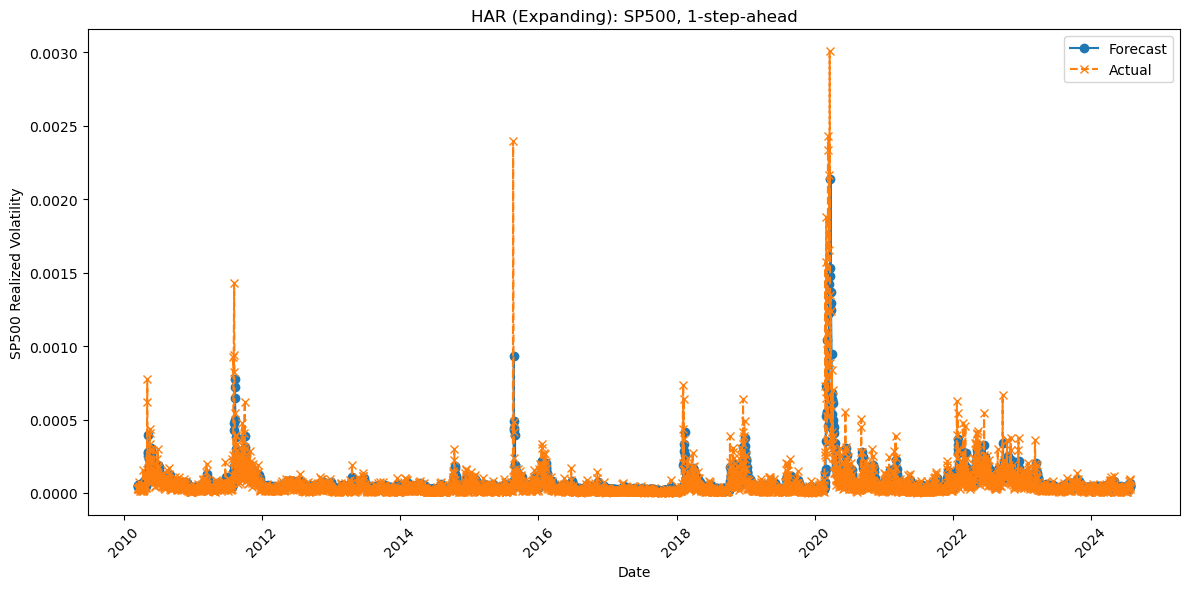

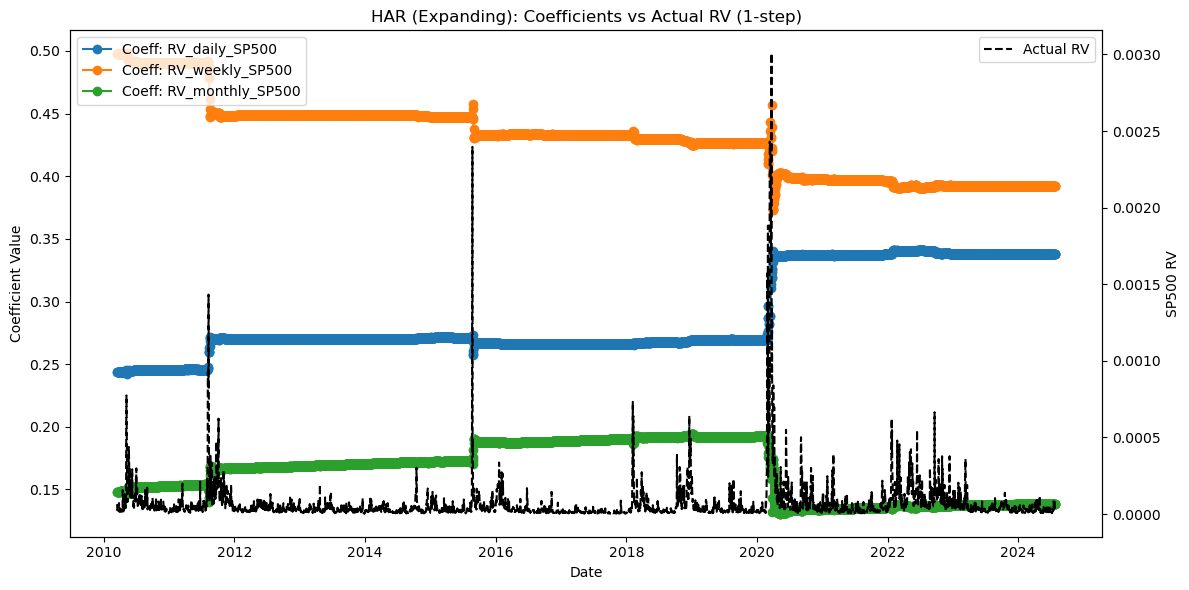

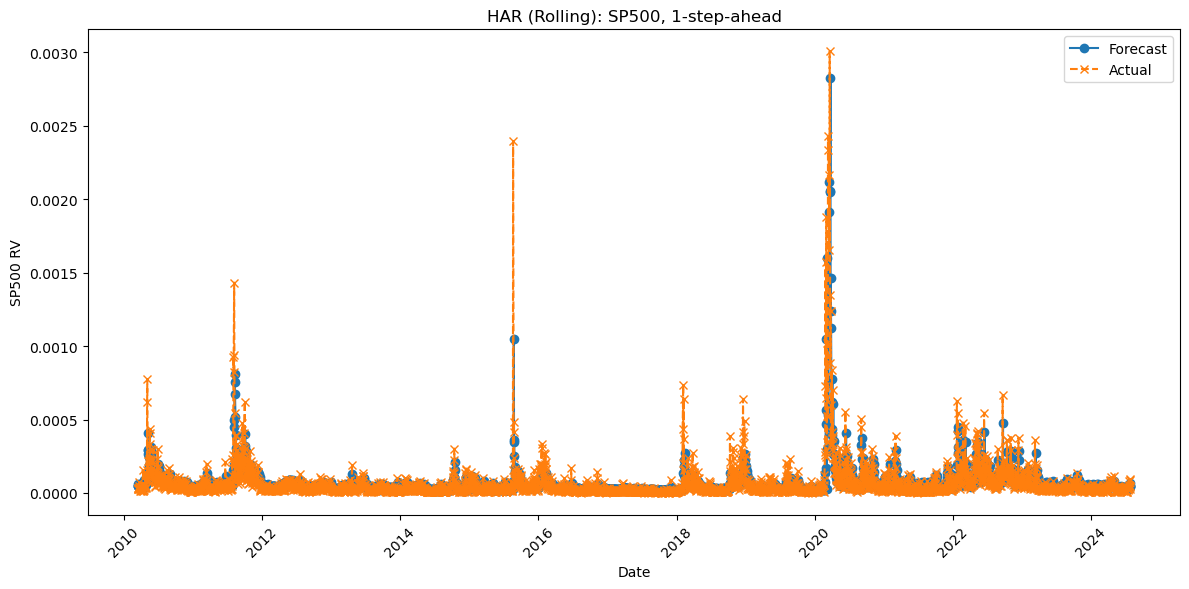

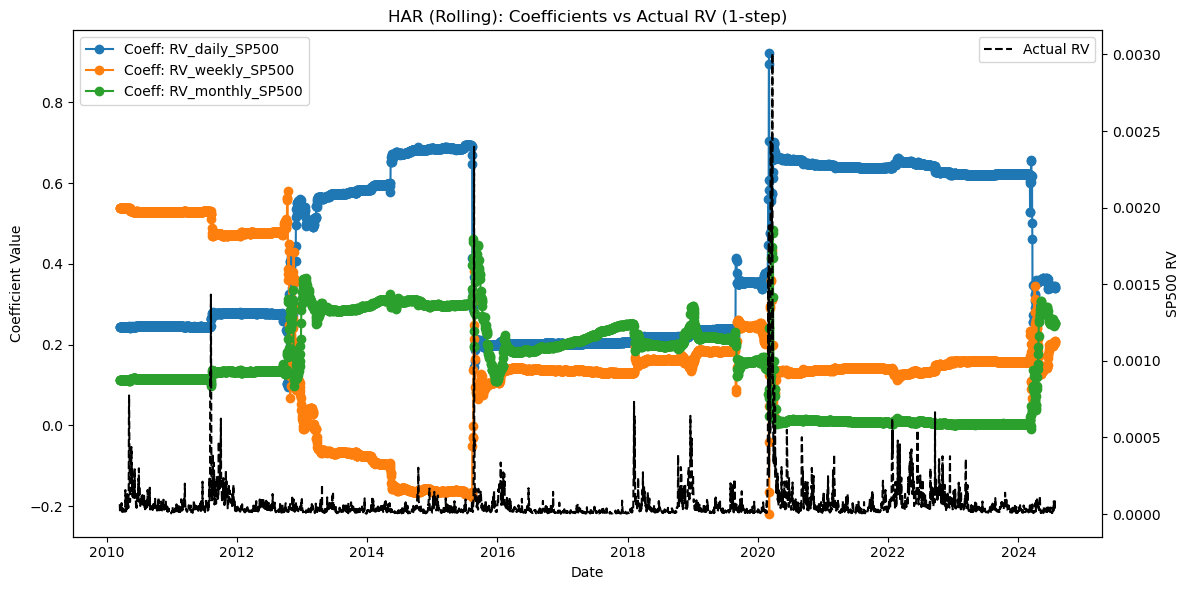

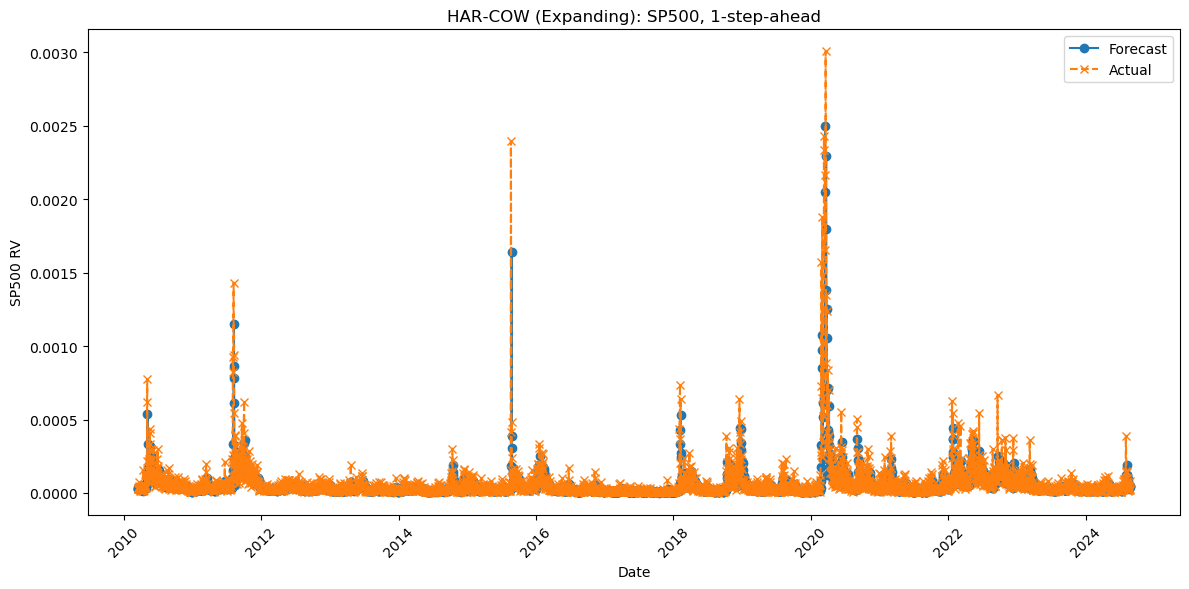

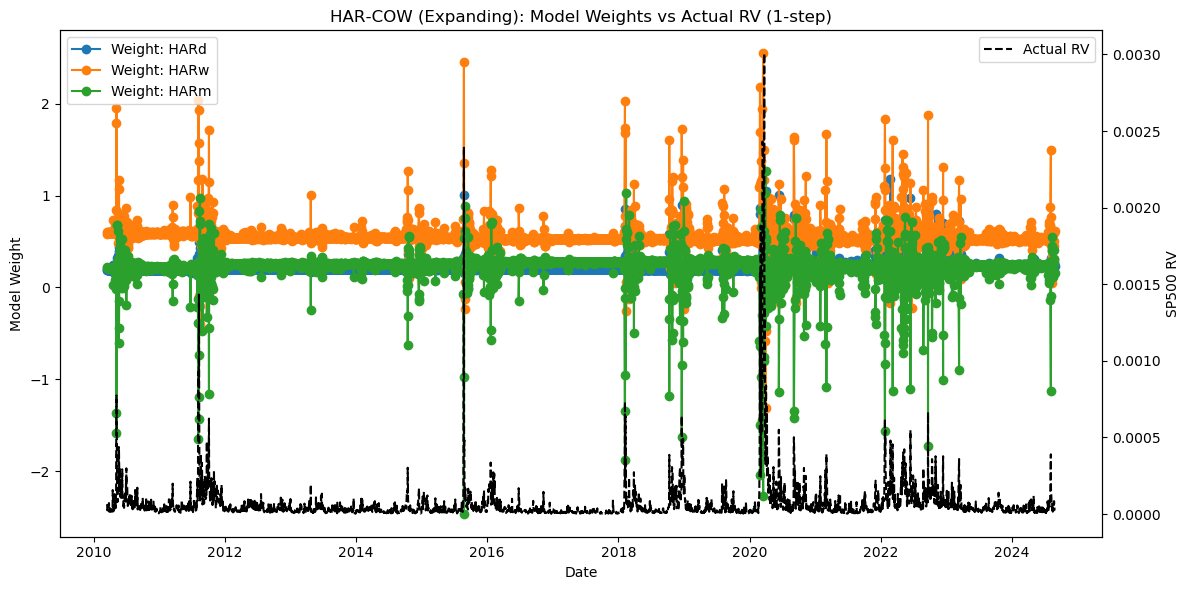

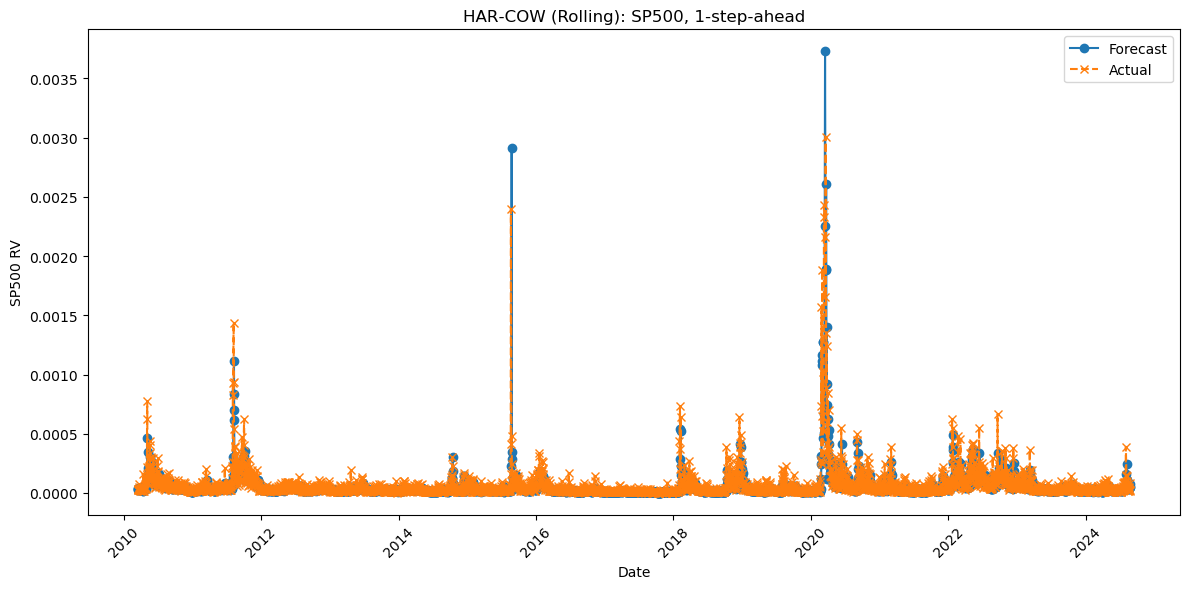

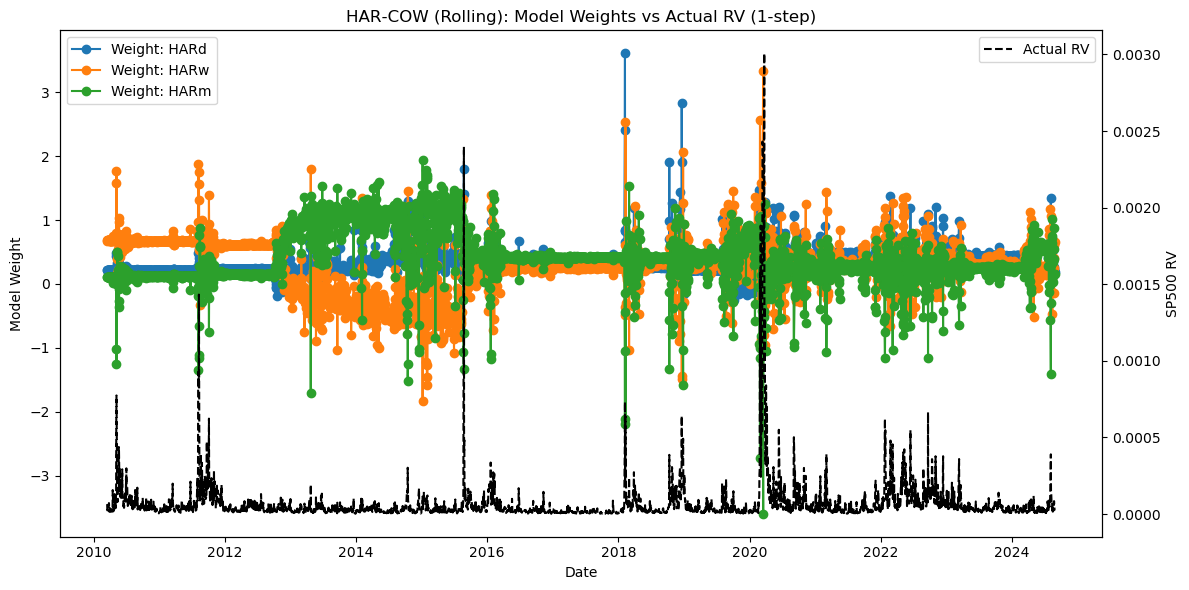

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 1  # 1-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW, we stored individual sub-model coefficients under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date (or you can modify this as needed)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑COW Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts are stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑COW Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

# For HAR‑COW, we stored individual model weights under key 'model_weights'
dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###############################################################################
# 7. HAR‑COW Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑COW Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, get the actual RV on the same dates
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 5-Step Forecast

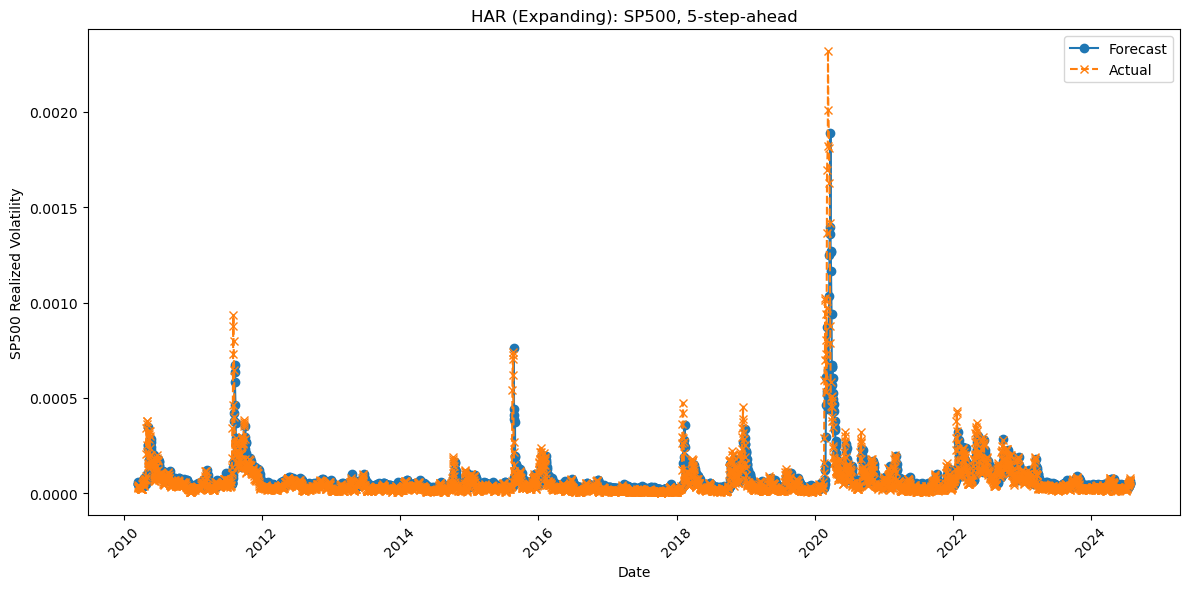

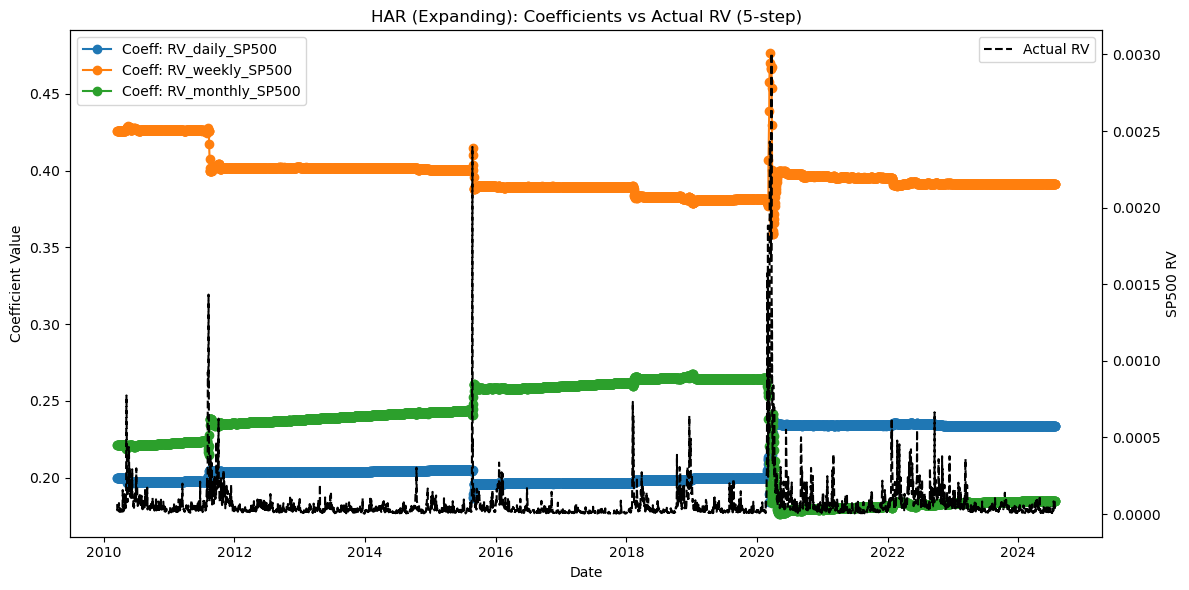

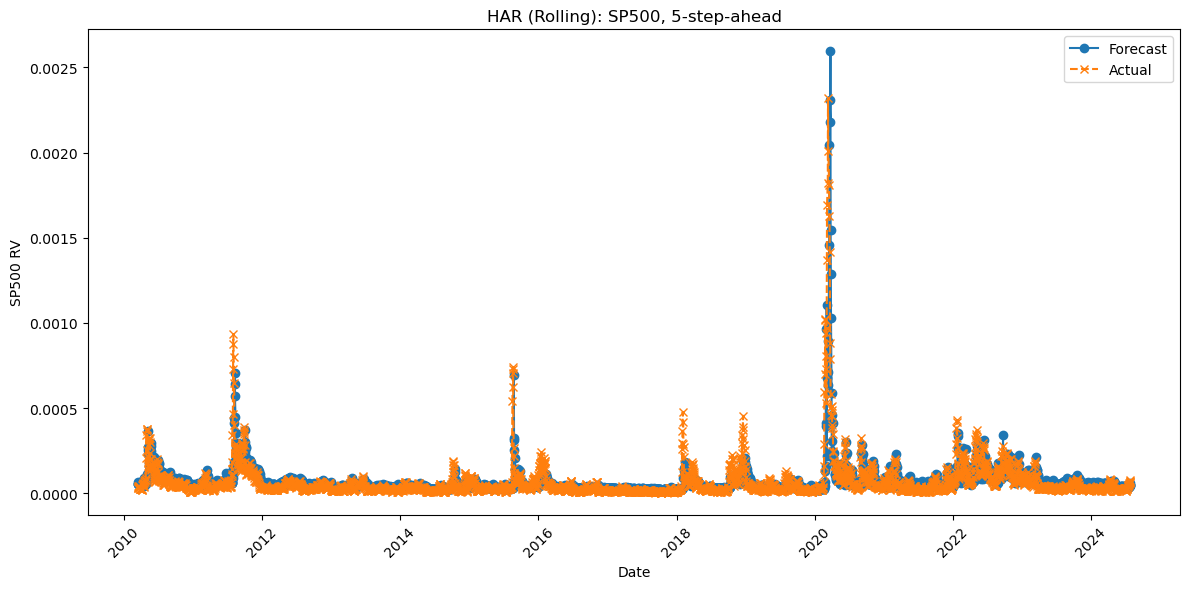

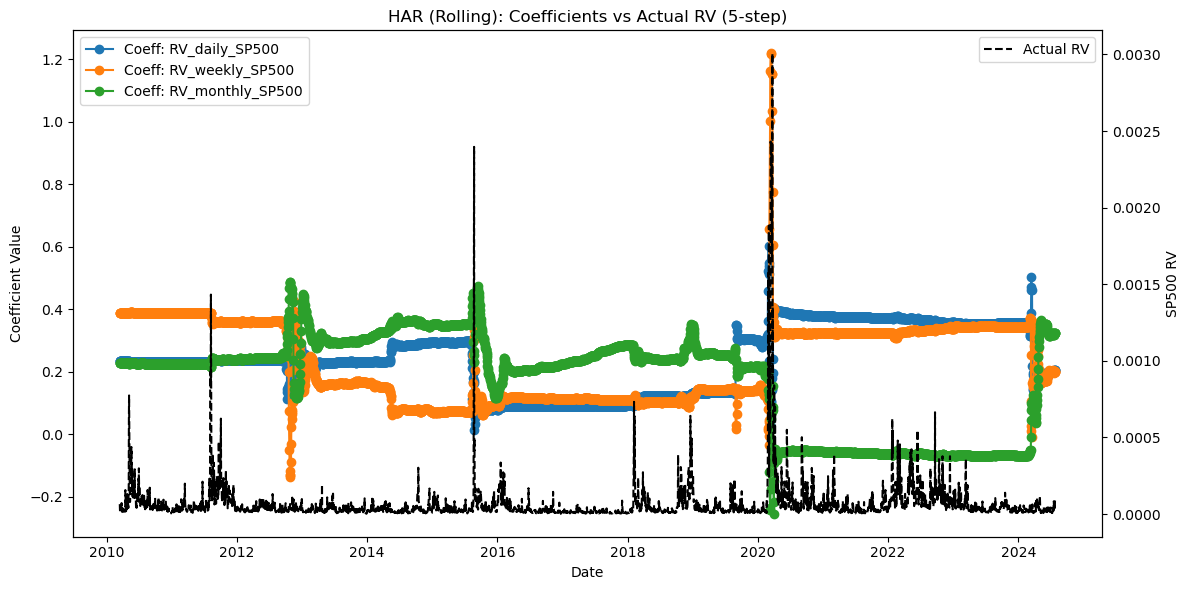

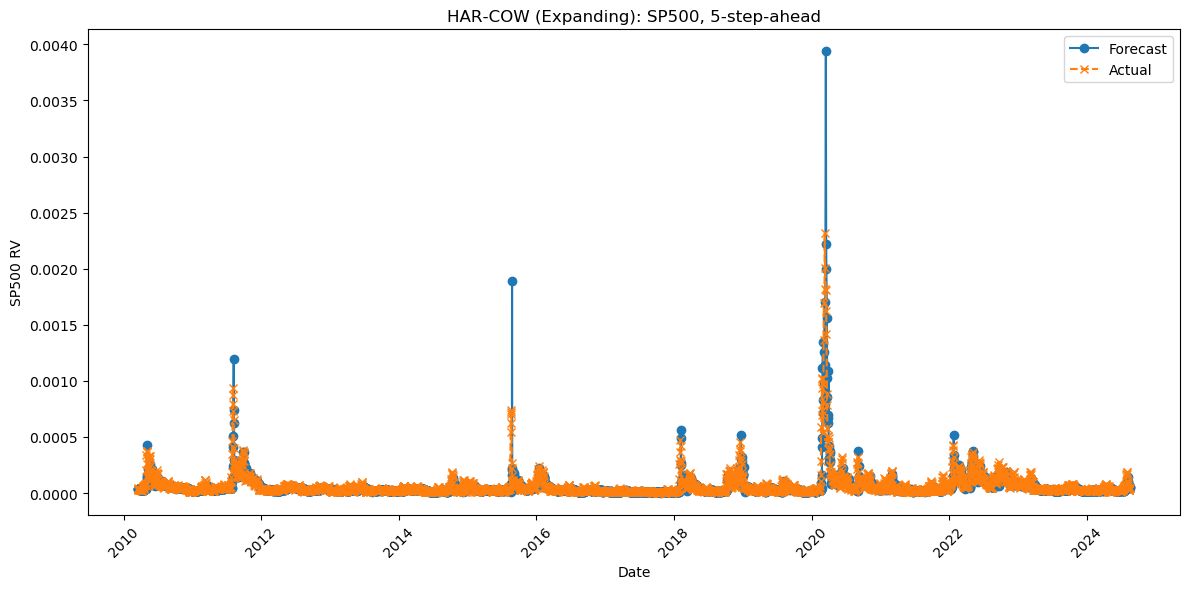

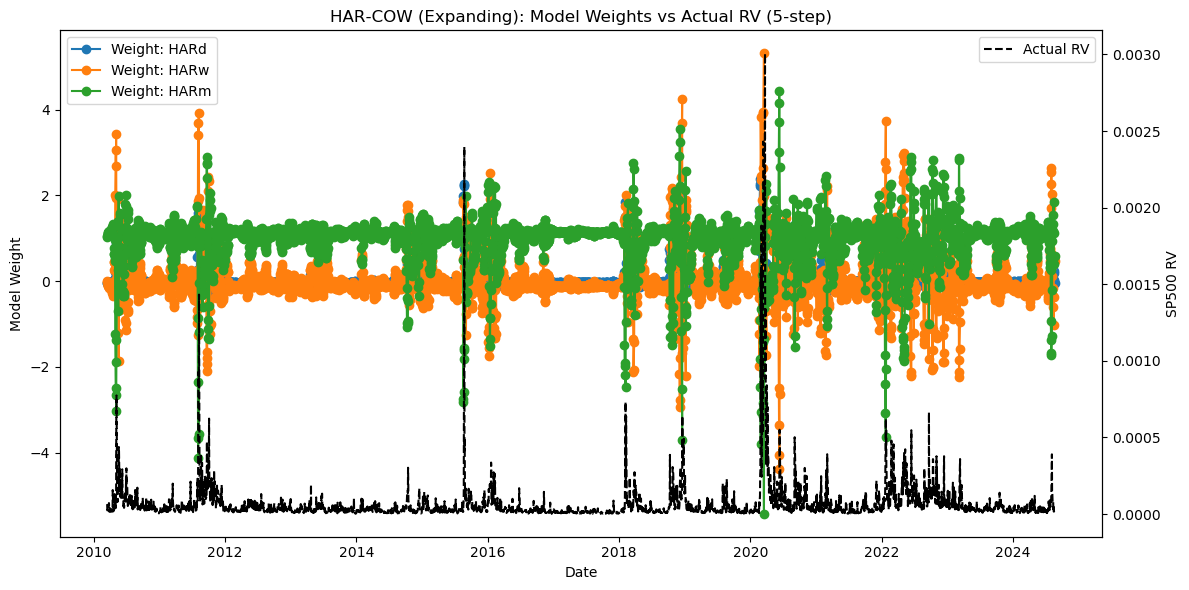

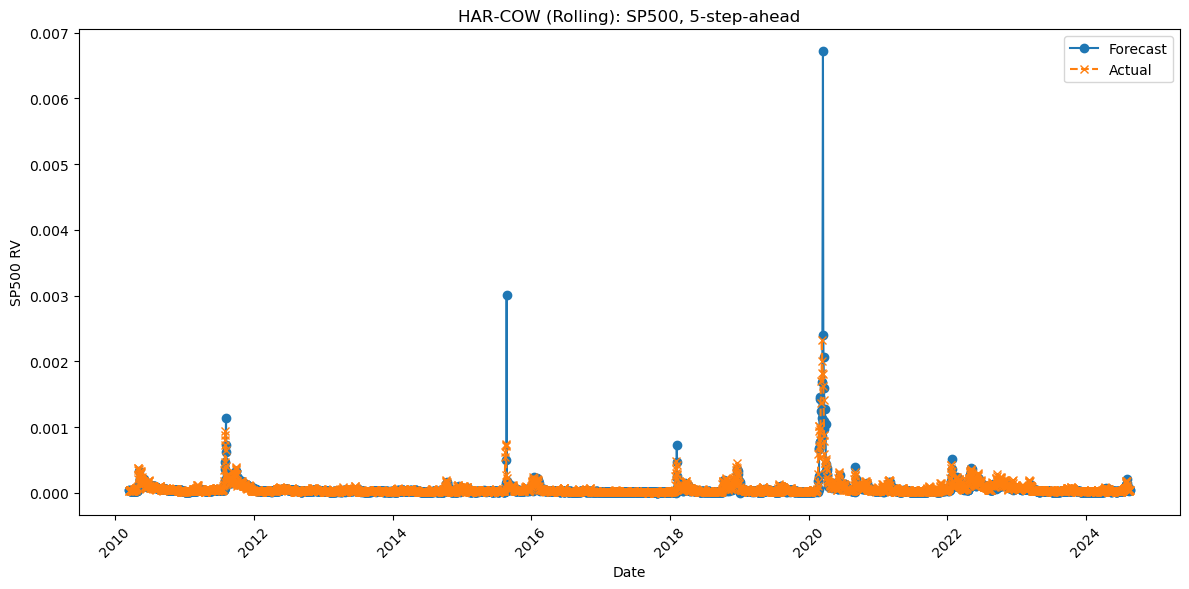

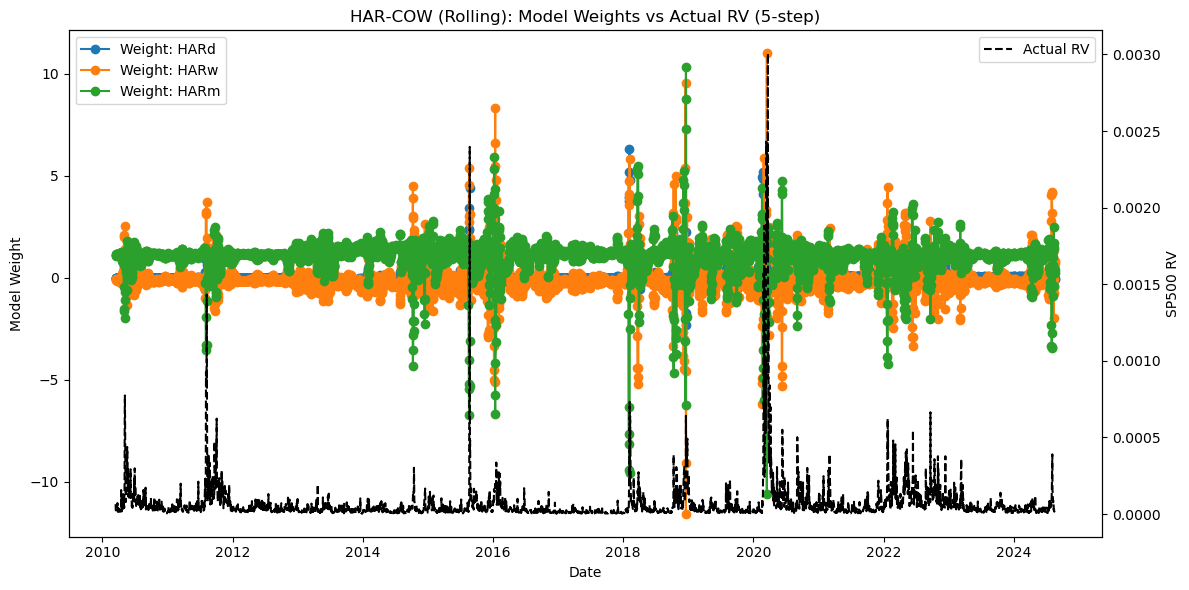

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 5  # 5-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW, we stored individual sub-model coefficients under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date (or you can modify this as needed)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑COW Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts are stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑COW Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

# For HAR‑COW, we stored individual model weights under key 'model_weights'
dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###############################################################################
# 7. HAR‑COW Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑COW Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, get the actual RV on the same dates
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 10-Step Forecast

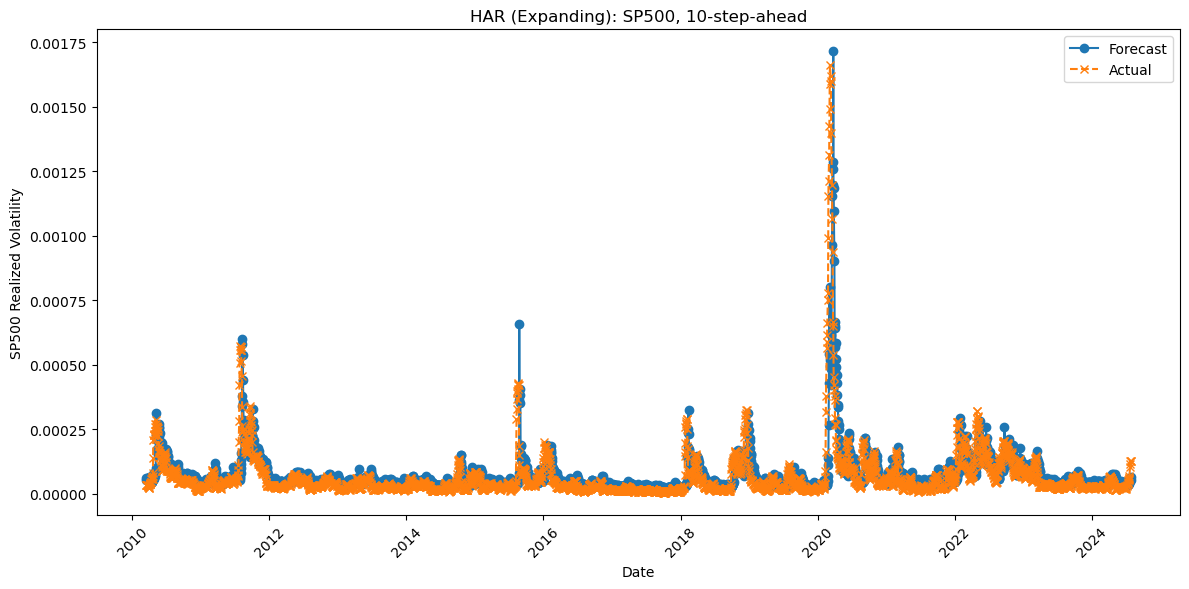

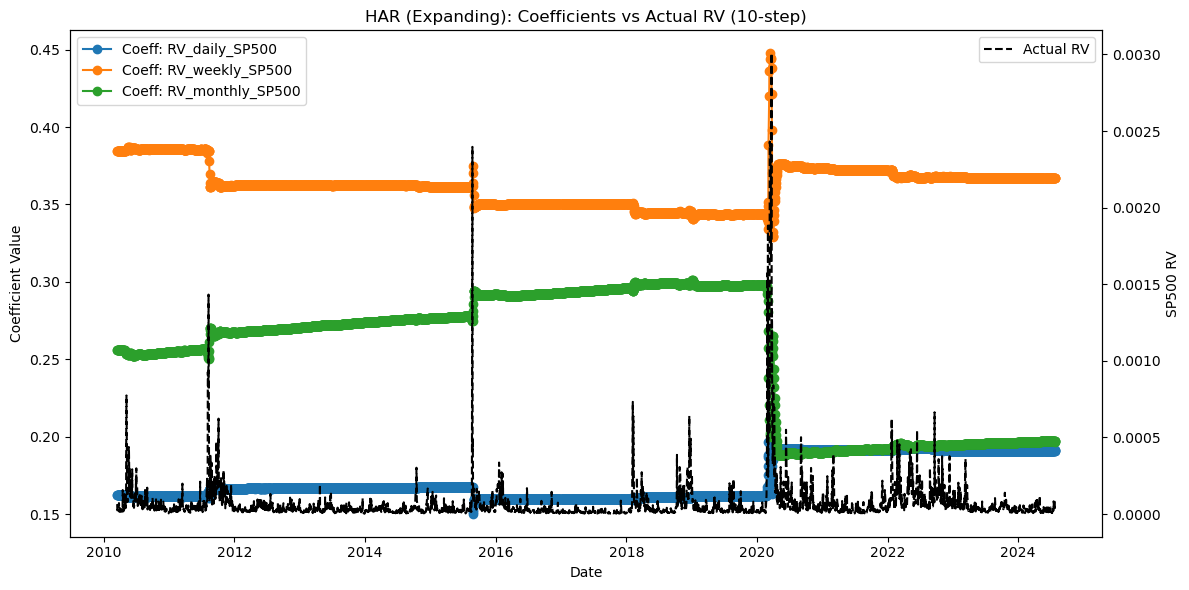

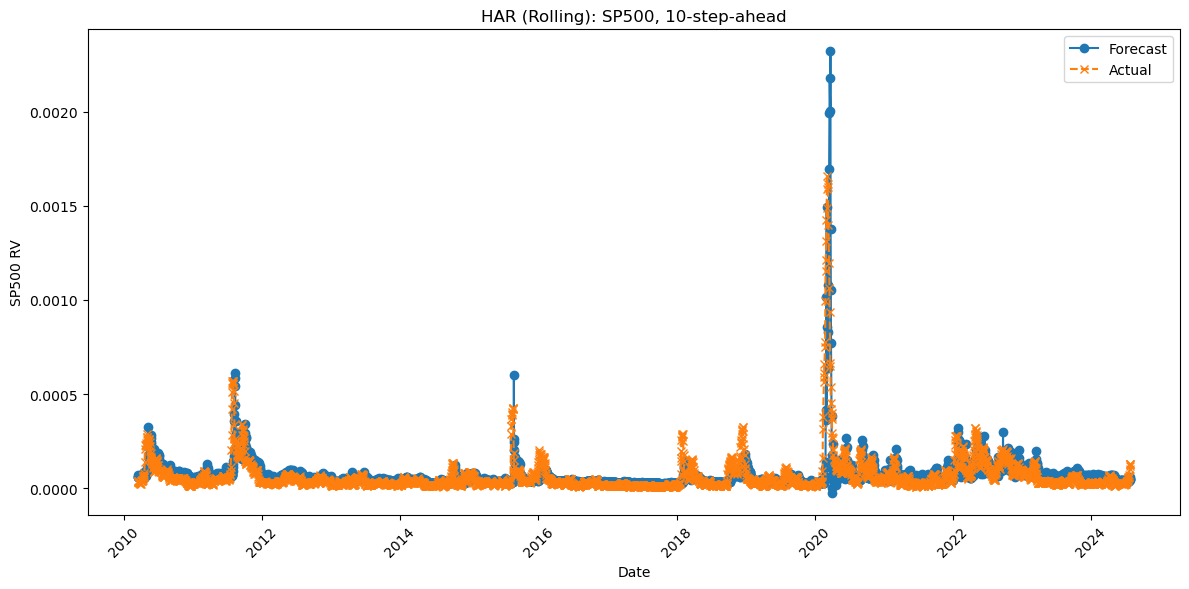

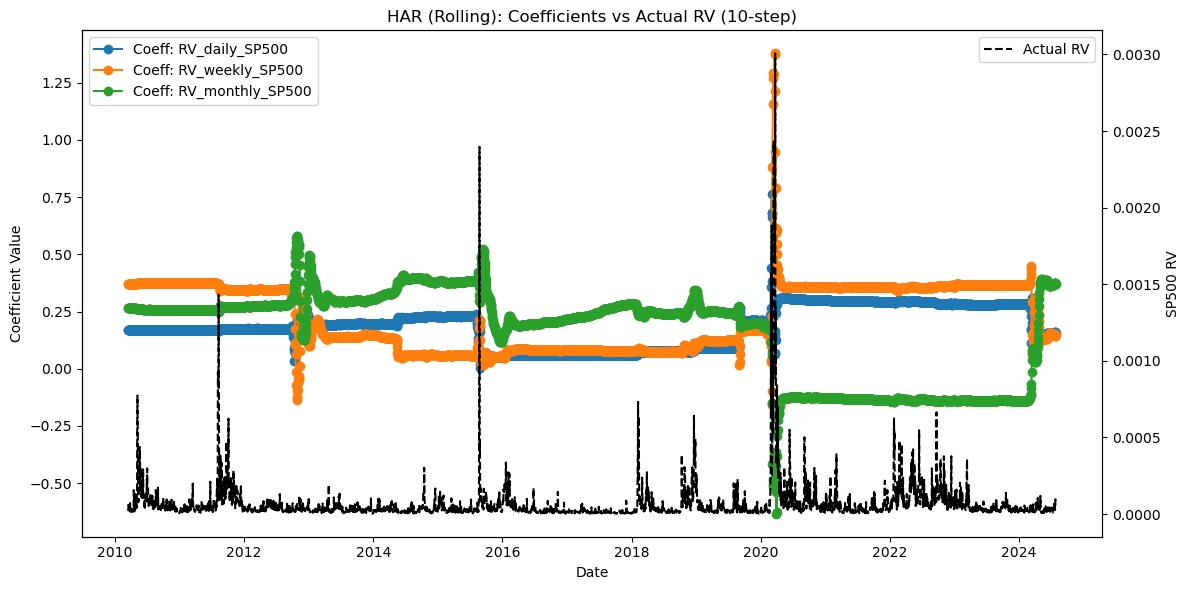

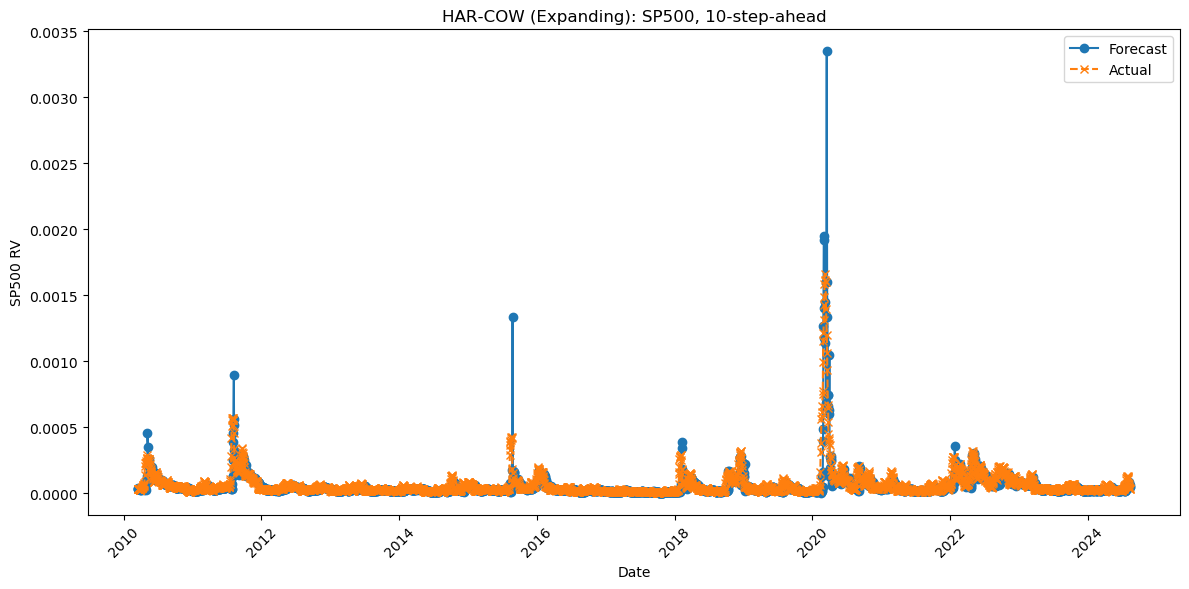

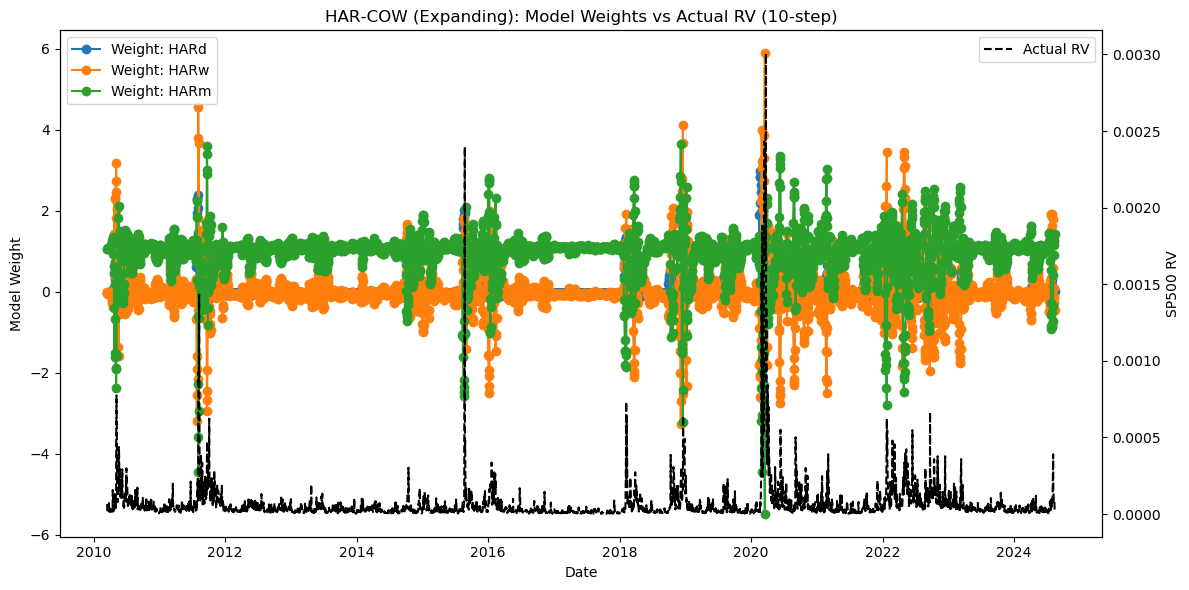

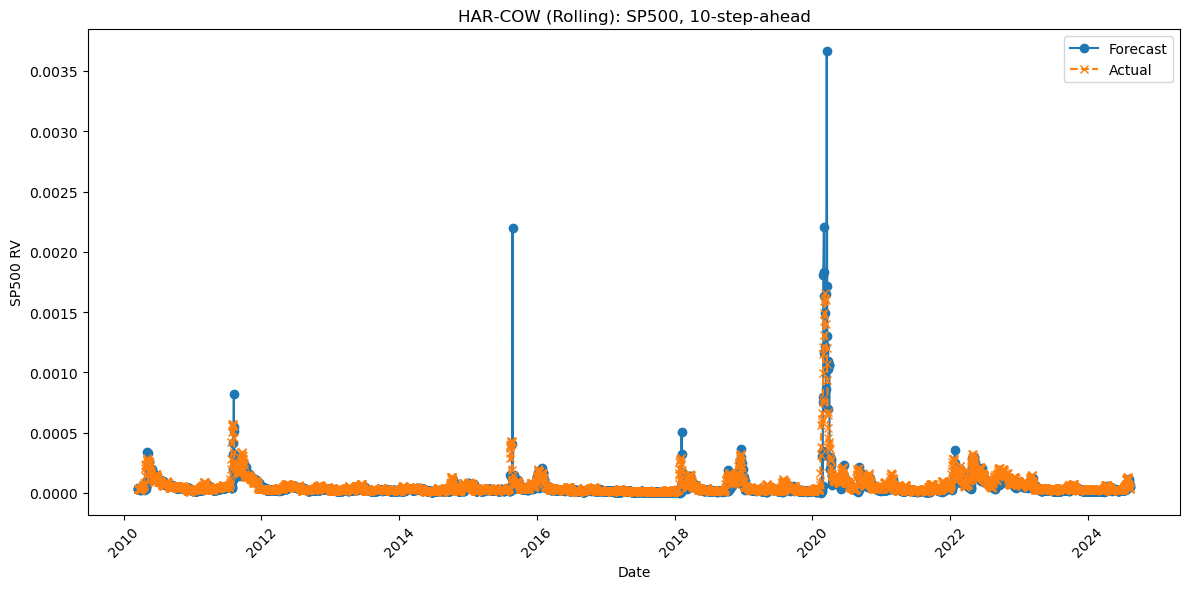

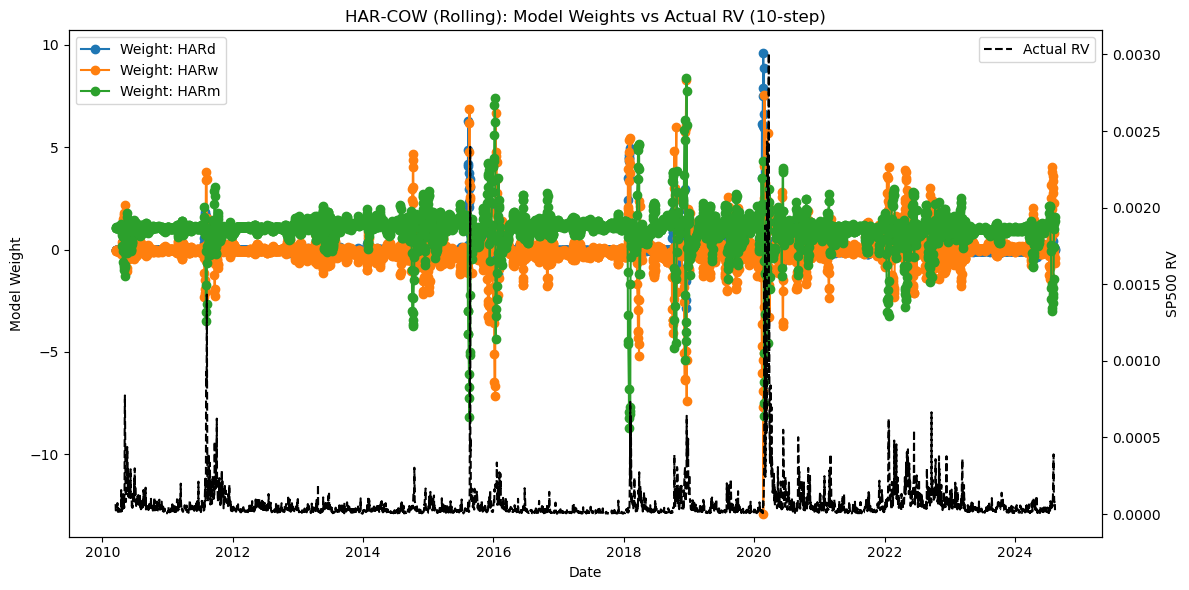

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 10  # 10-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW, we stored individual sub-model coefficients under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date (or you can modify this as needed)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑COW Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts are stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑COW Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

# For HAR‑COW, we stored individual model weights under key 'model_weights'
dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###############################################################################
# 7. HAR‑COW Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑COW Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, get the actual RV on the same dates
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 22-Step Forecast

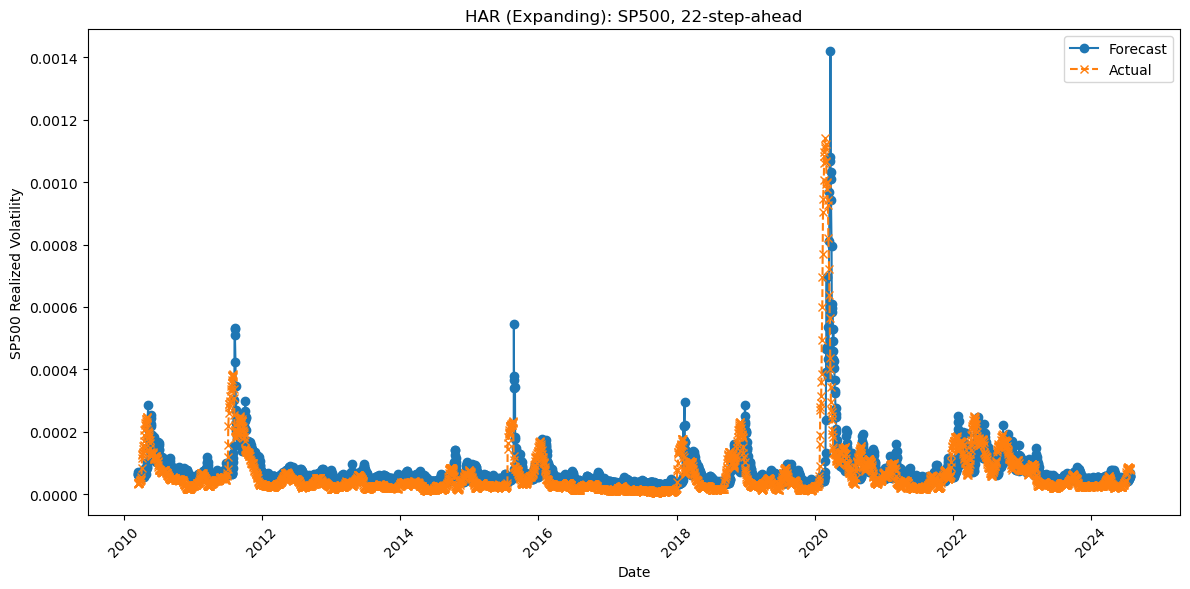

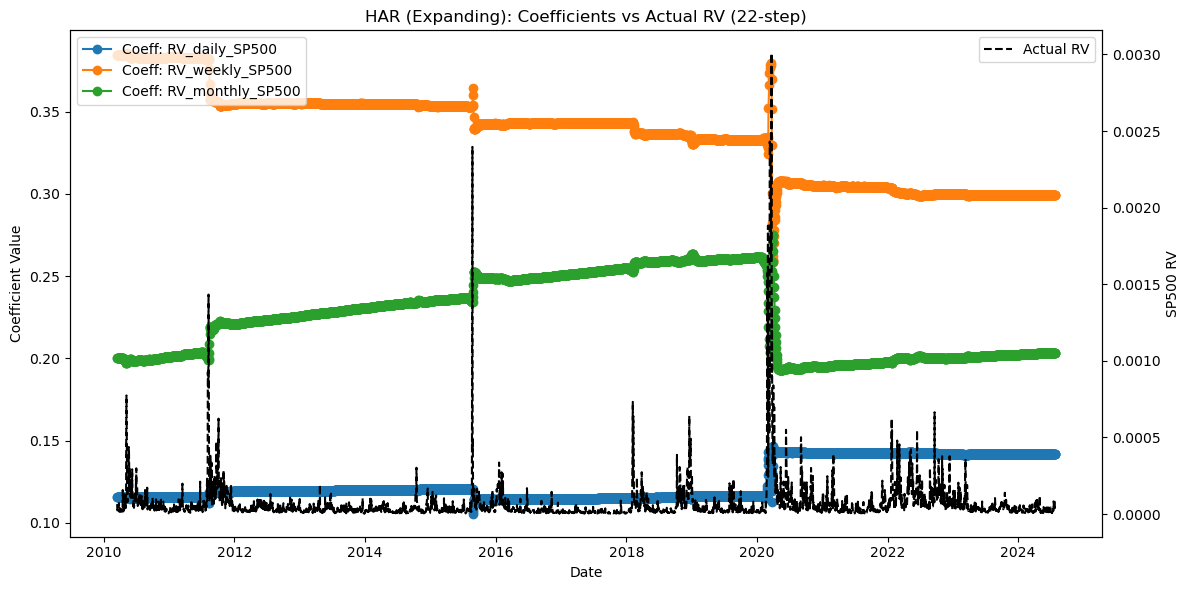

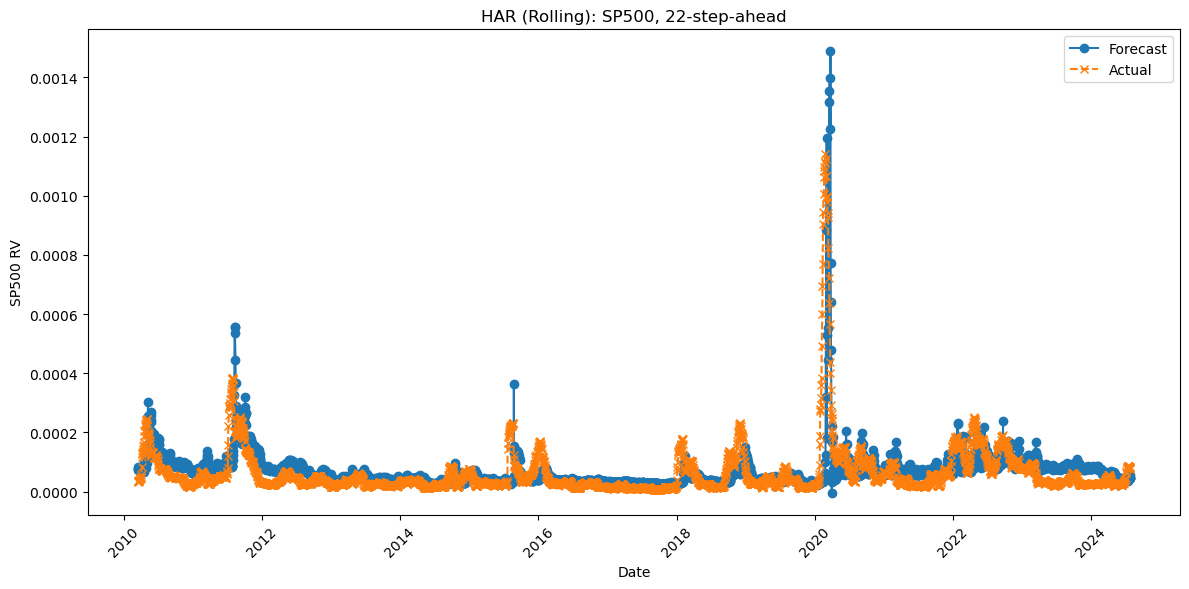

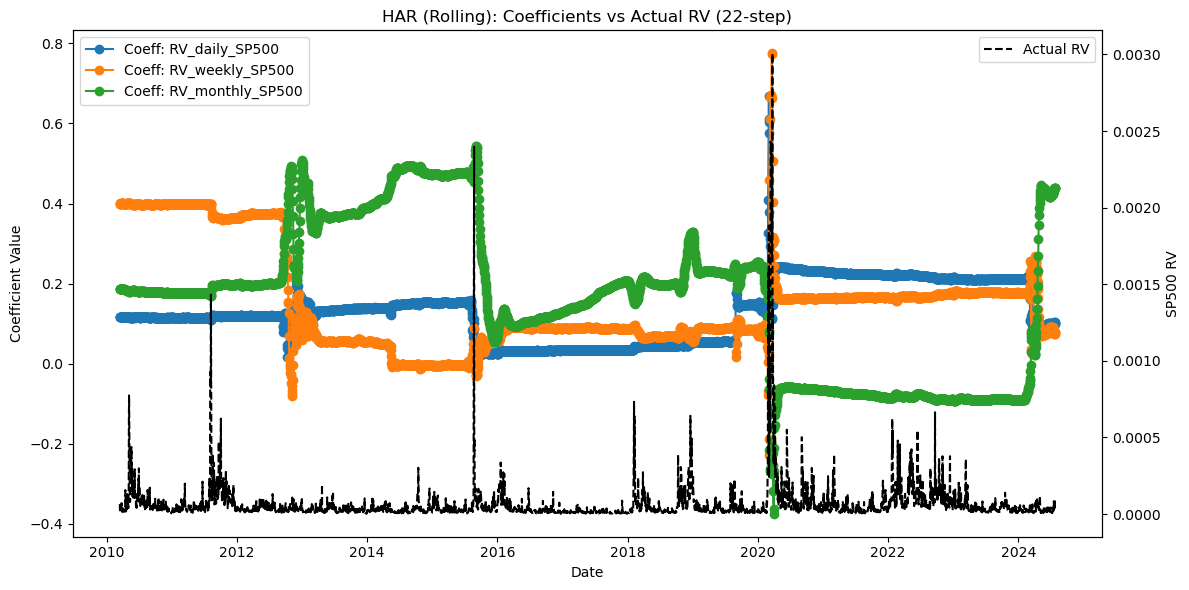

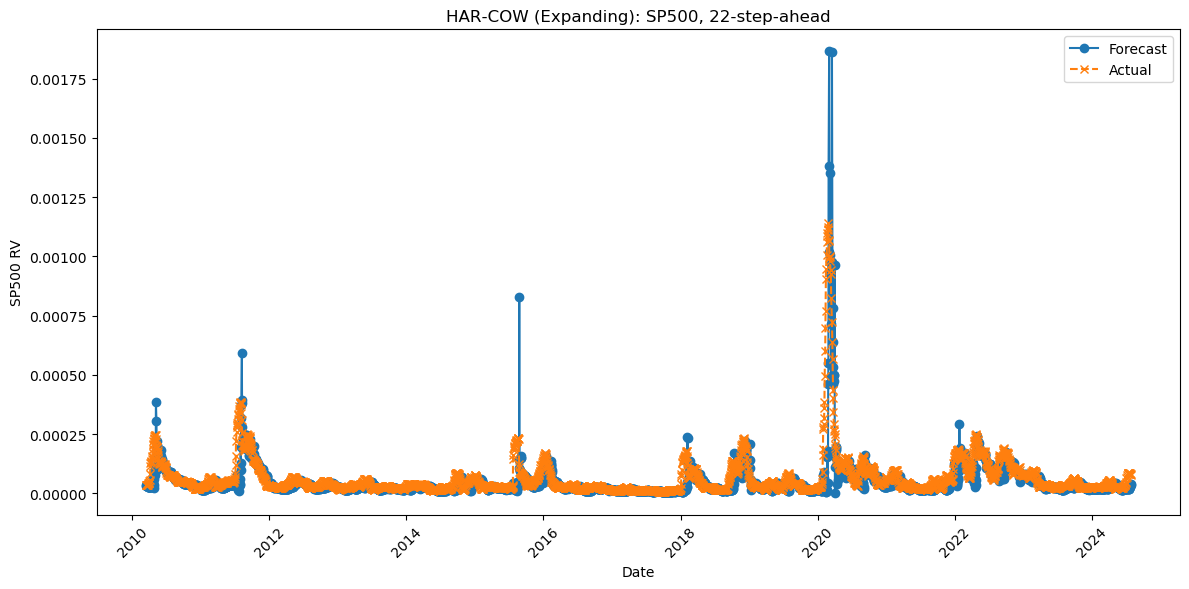

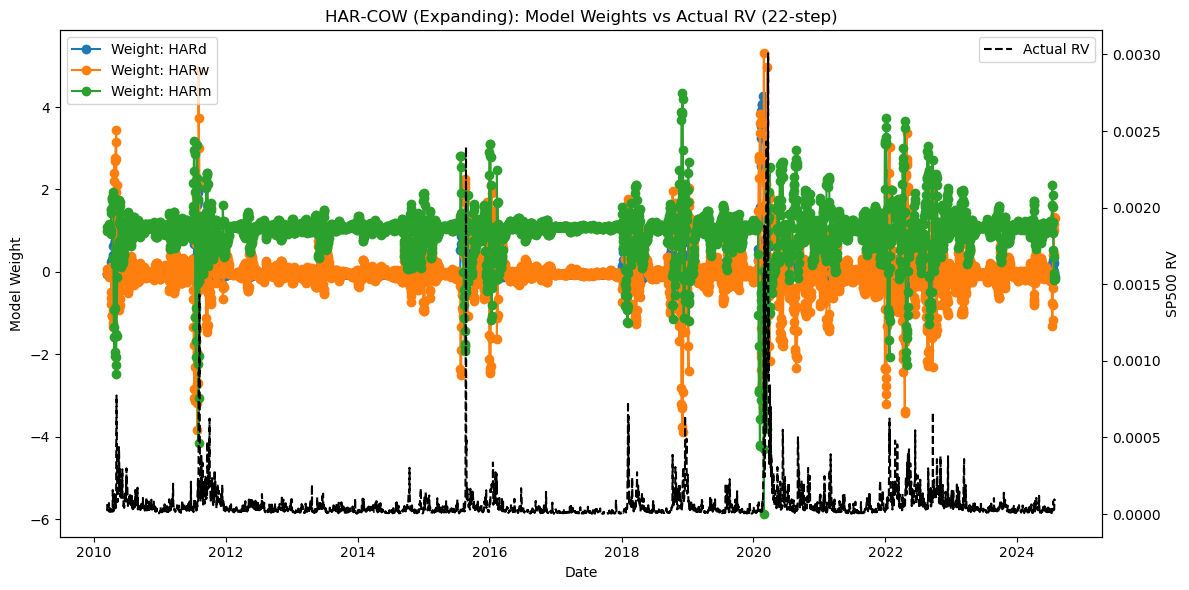

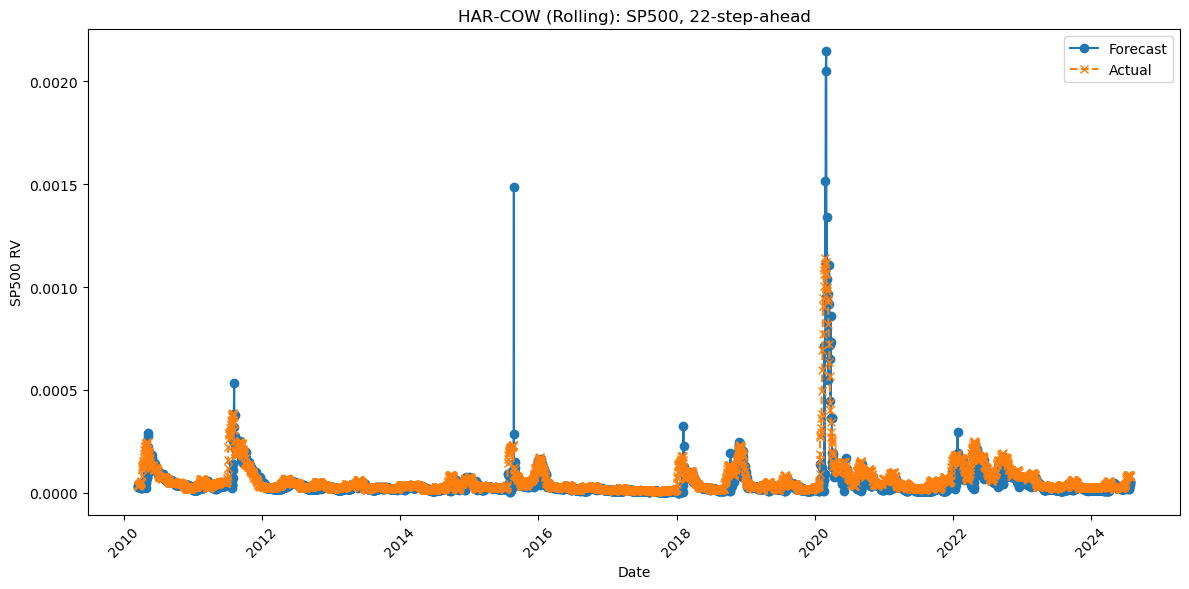

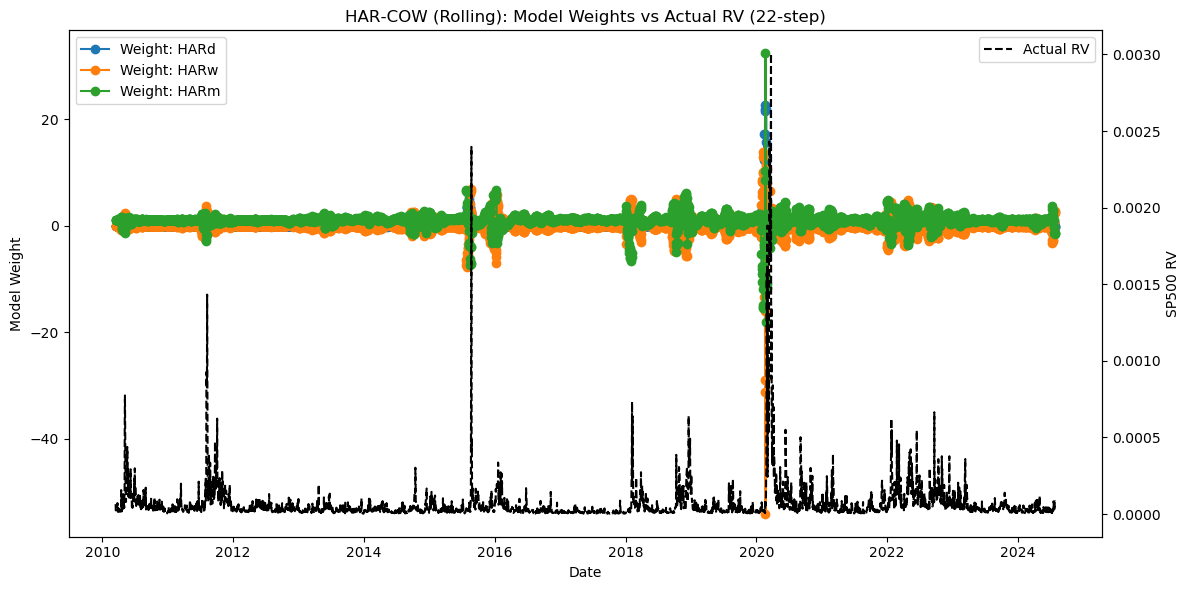

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 22  # 22-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW, we stored individual sub-model coefficients under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date (or you can modify this as needed)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑COW Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts are stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑COW Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

# For HAR‑COW, we stored individual model weights under key 'model_weights'
dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###############################################################################
# 7. HAR‑COW Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑COW Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, get the actual RV on the same dates
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## HAR OW3 Graph (22-Step Ahead)

ERROR! Session/line number was not unique in database. History logging moved to new session 17


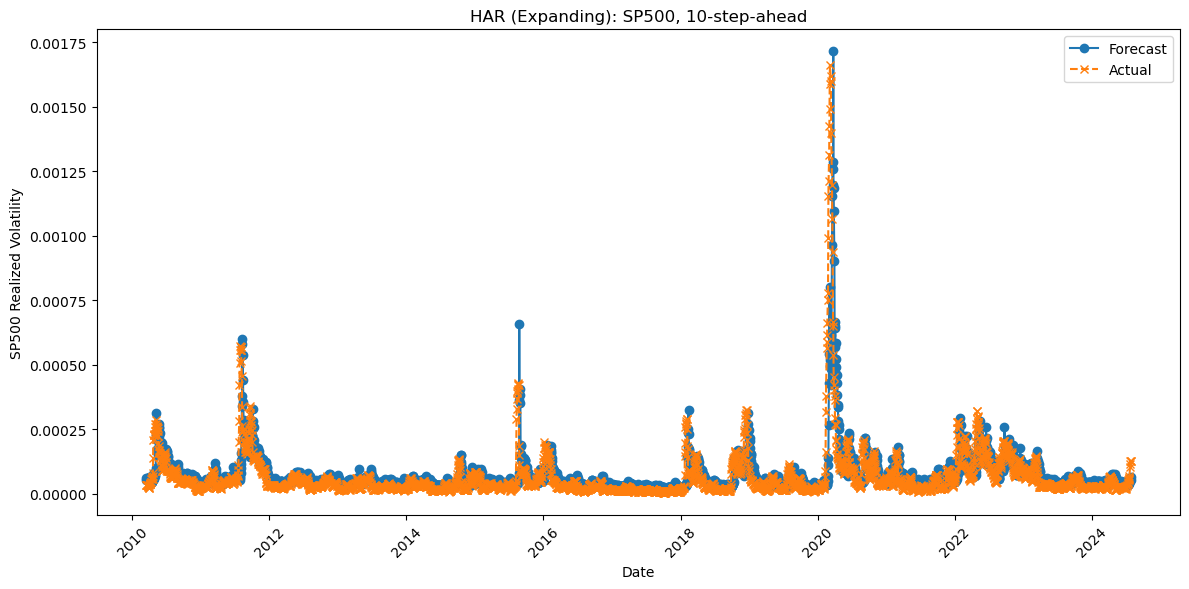

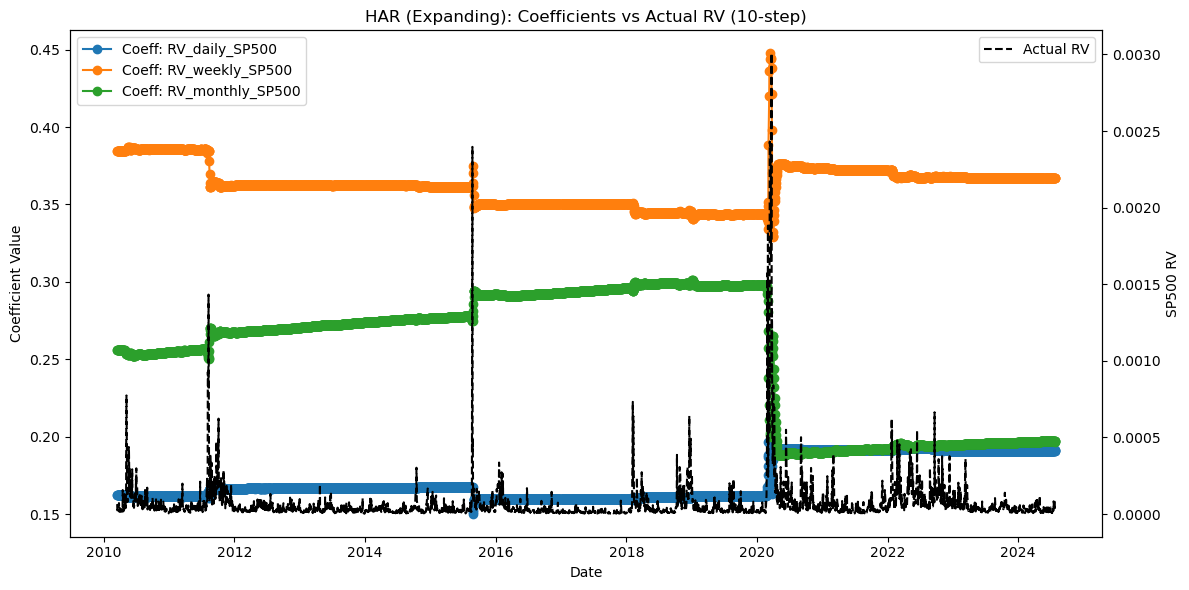

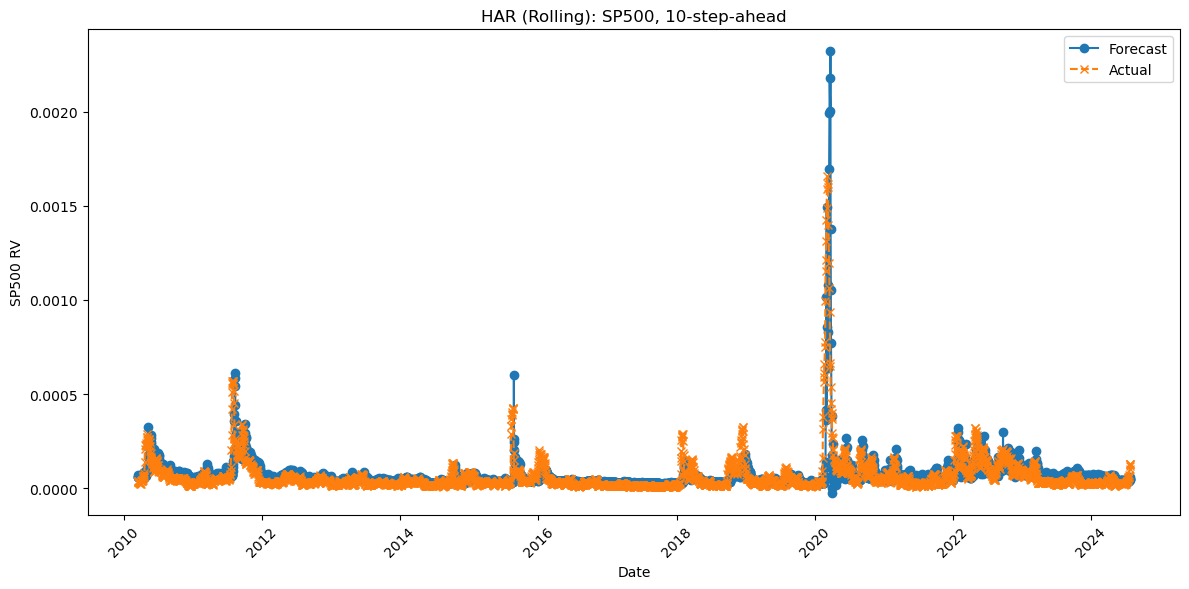

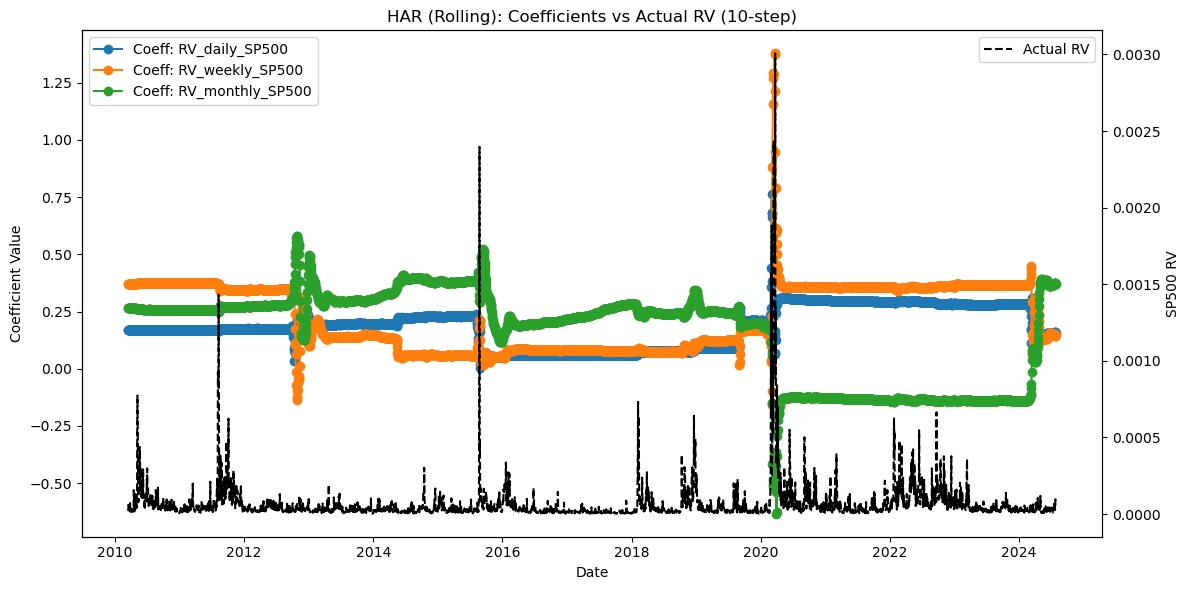

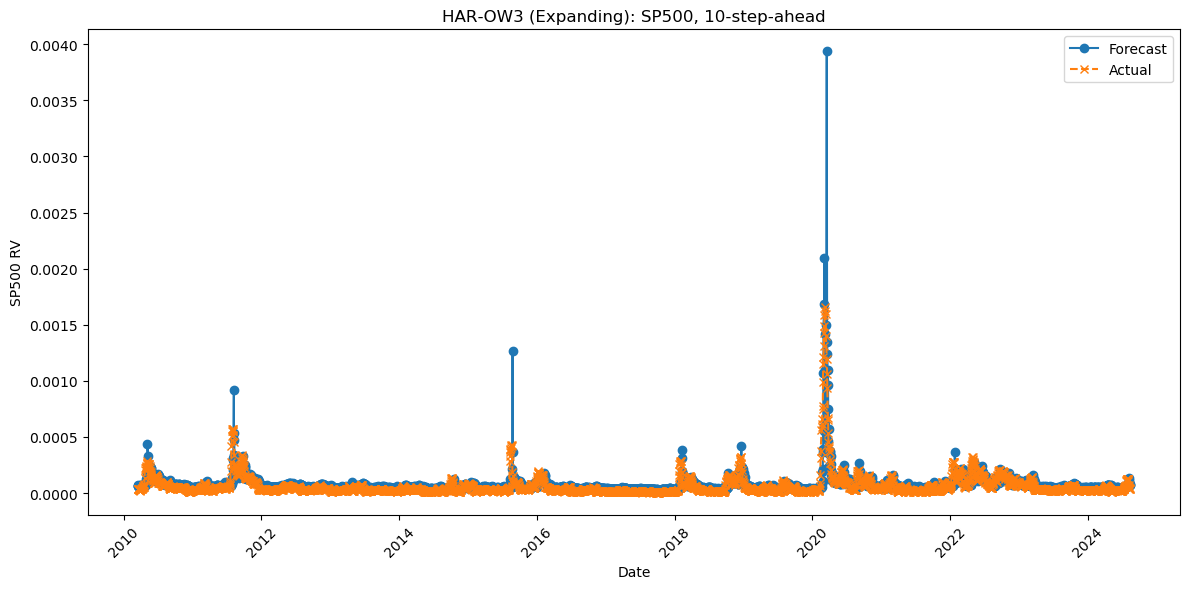

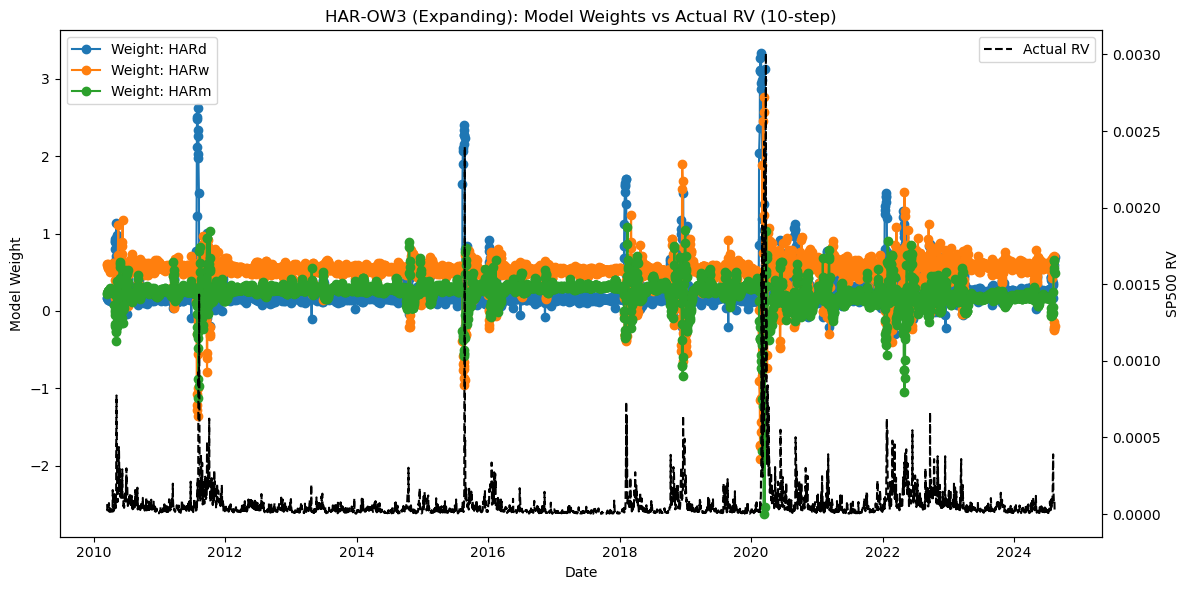

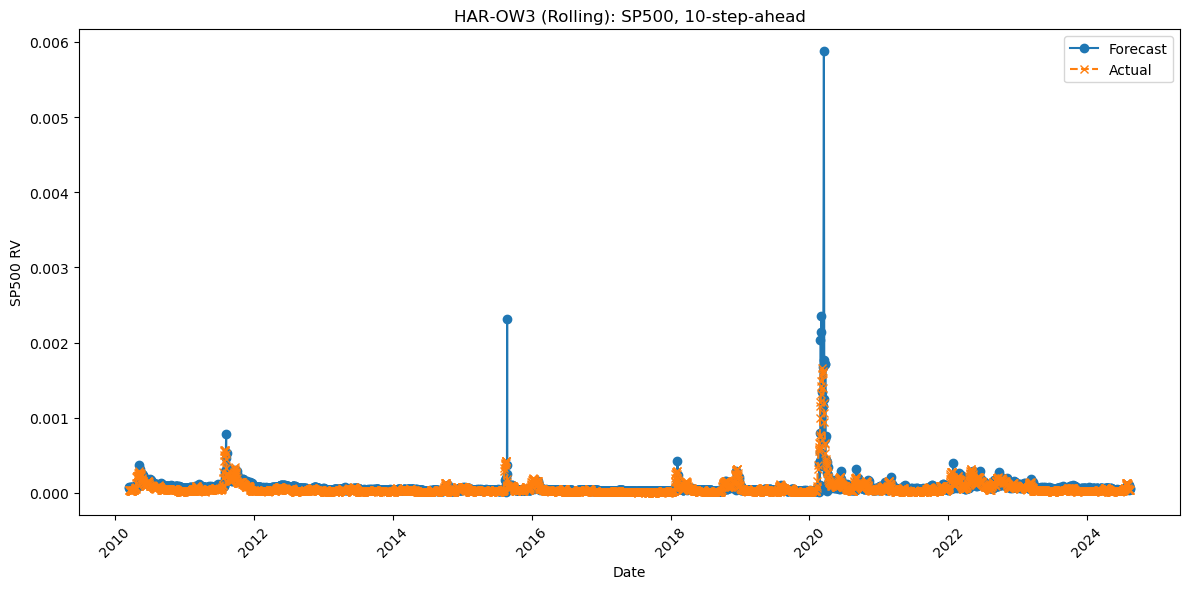

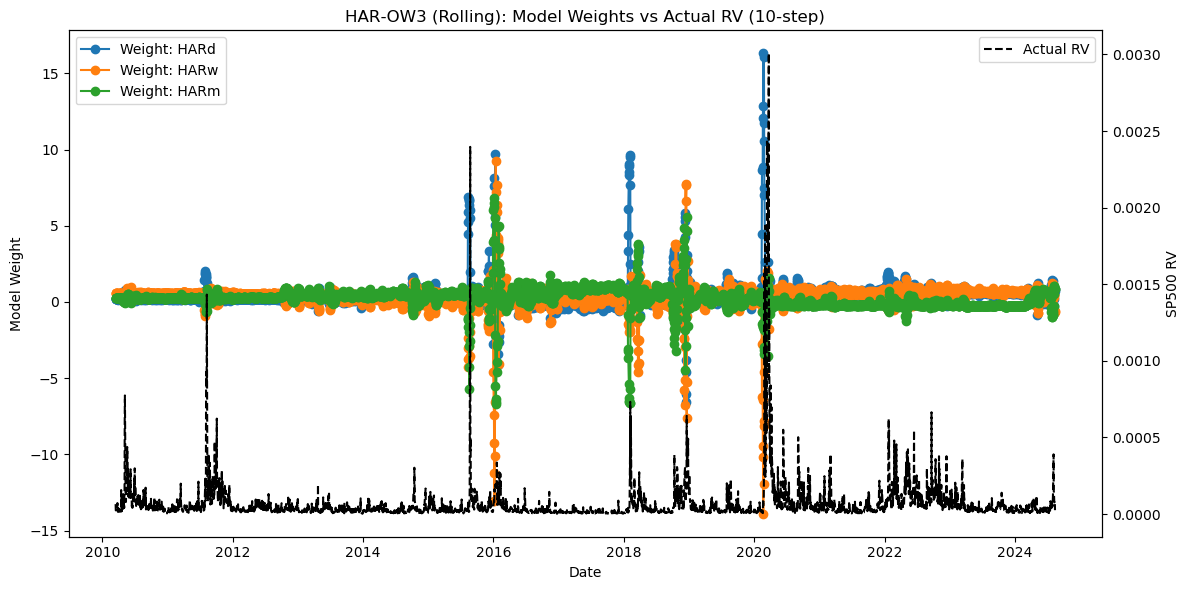

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 22  # 10-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW, we stored individual sub-model coefficients under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date (or you can modify this as needed)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', label=f'Coeff: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑OW3 Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Expanding)'
results = results_HAR_OW3_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts are stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑OW3 Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Expanding)'
results = results_HAR_OW3_expanding

# For HAR‑COW, we stored individual model weights under key 'model_weights'
dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, we use the actual RV on the same date
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###############################################################################
# 7. HAR‑OW3 Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Rolling)'
results = results_HAR_OW3_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, 'o-', label='Forecast')
plt.plot(dates, actuals, 'x--', label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑OW3 Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Rolling)'
results = results_HAR_OW3_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

# For reference, get the actual RV on the same dates
for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', label=f'Weight: {key}')
    
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, 'k--', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

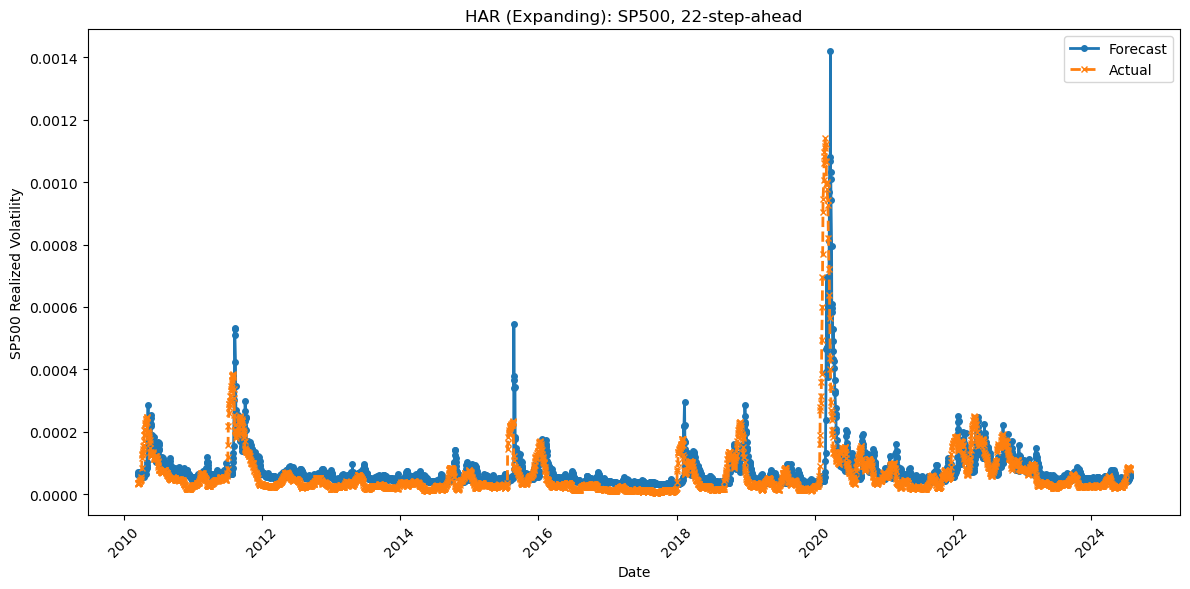

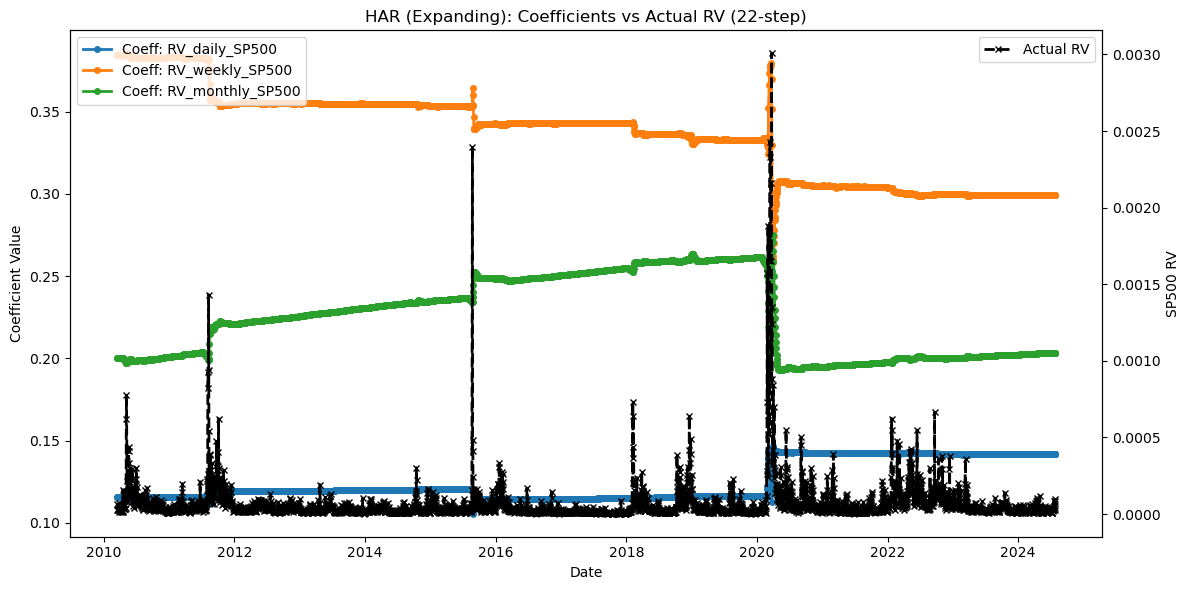

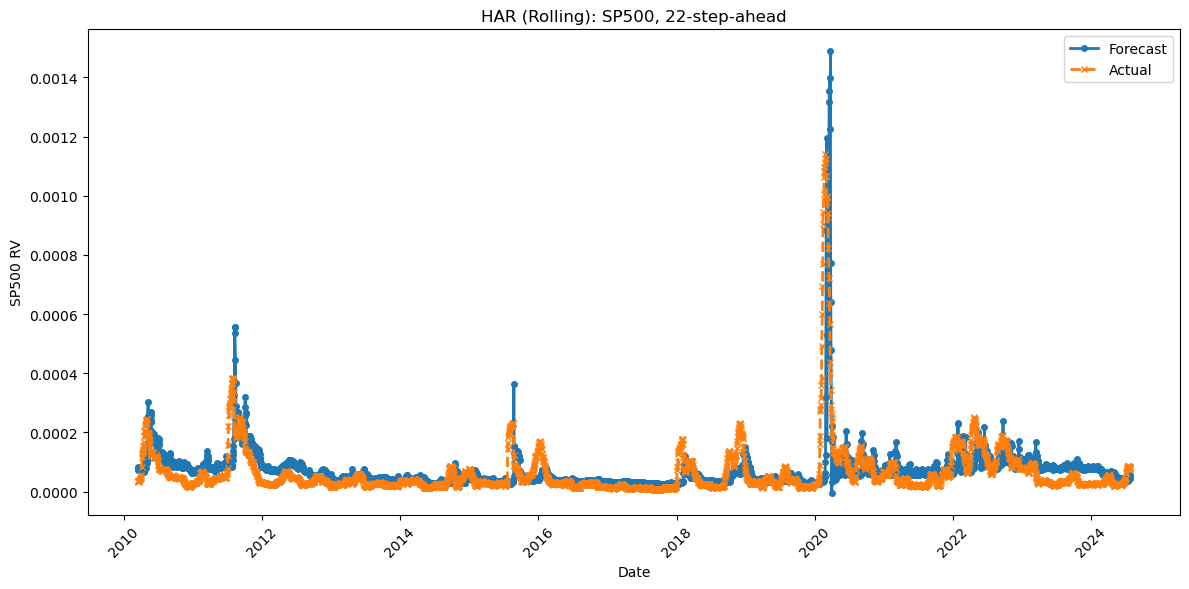

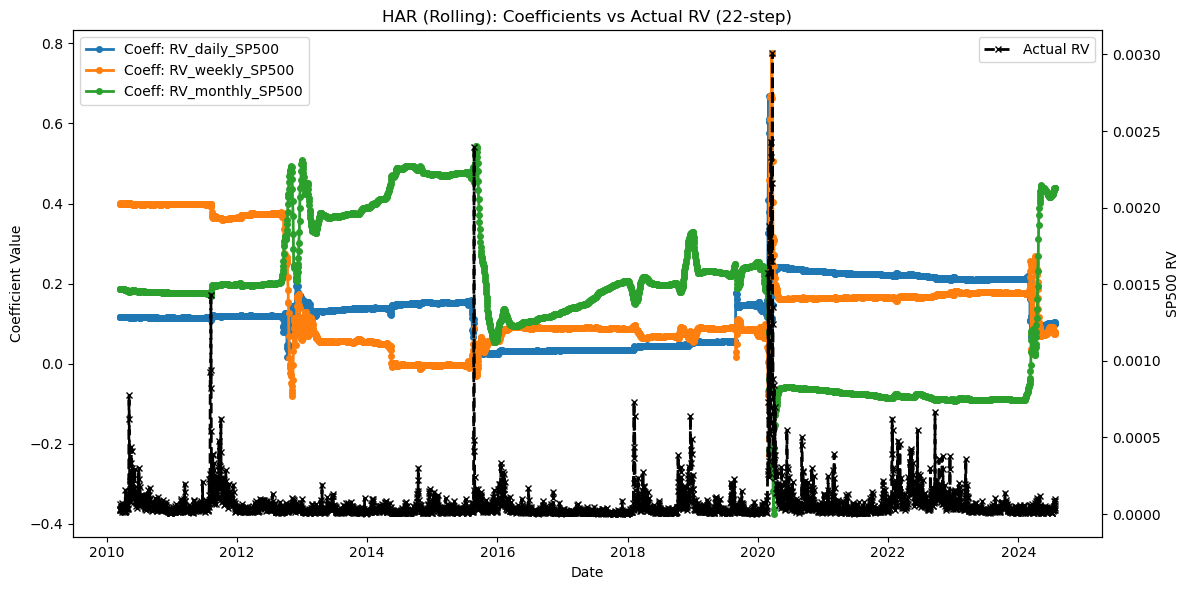

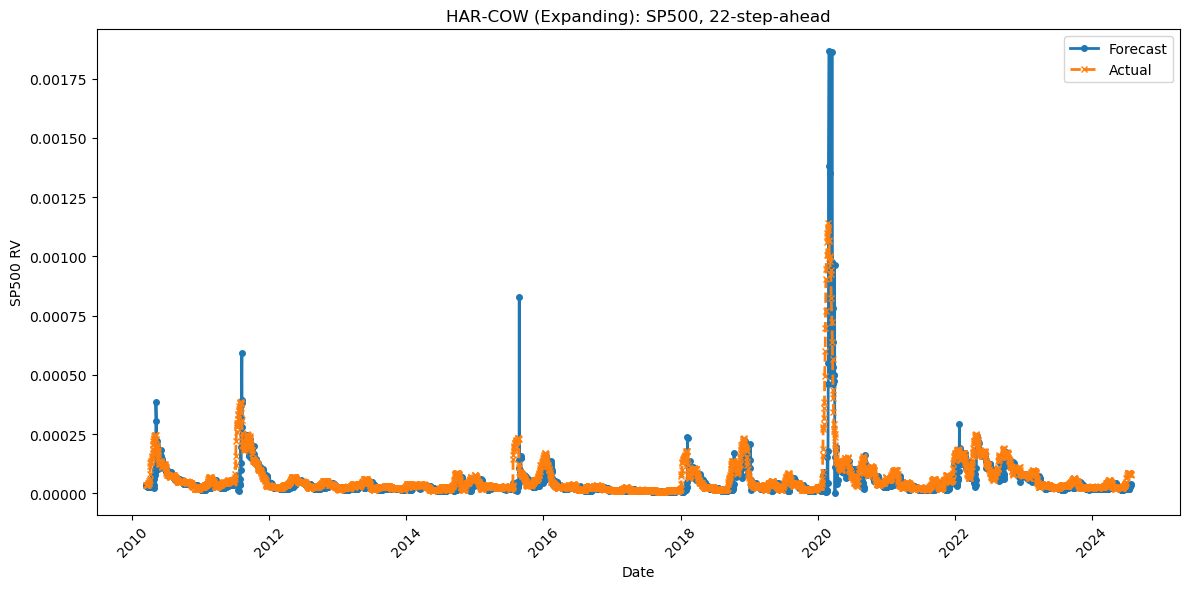

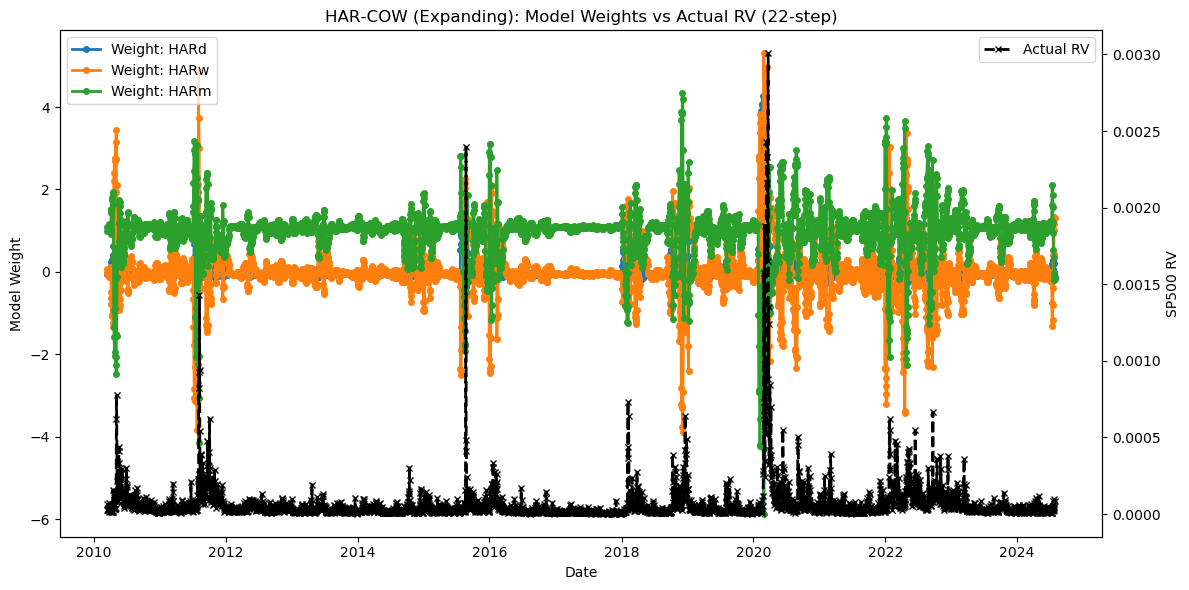

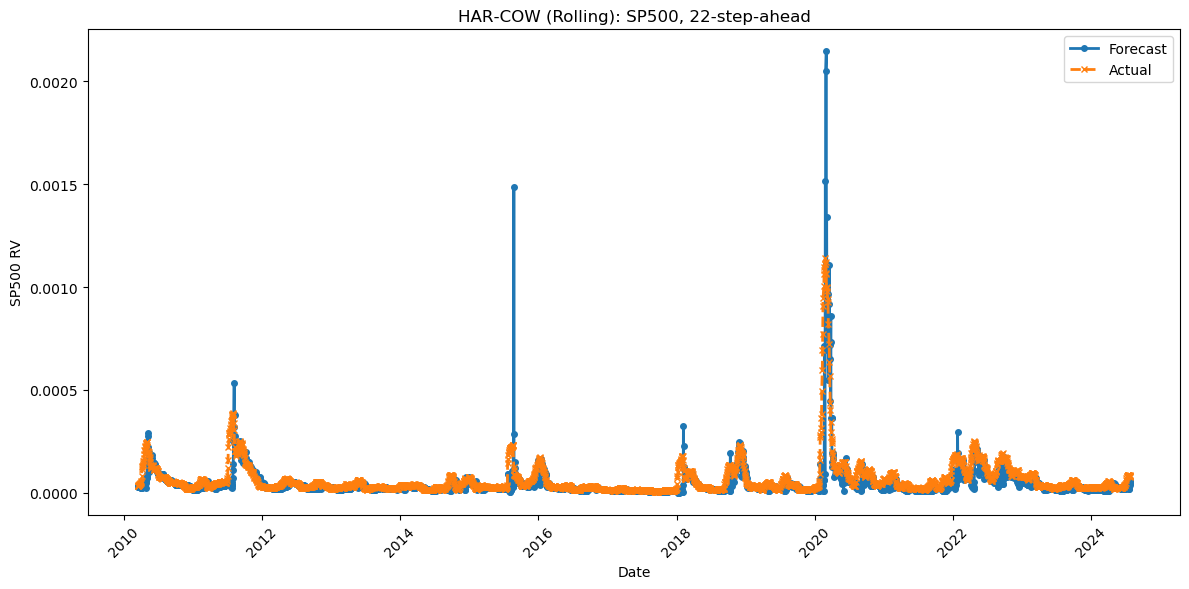

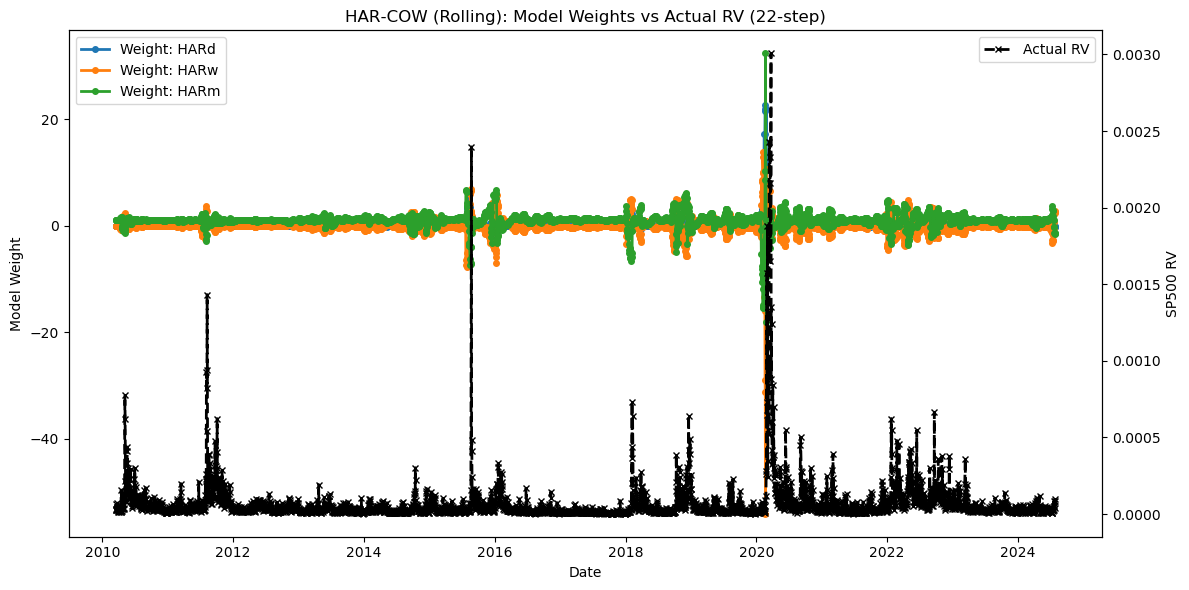

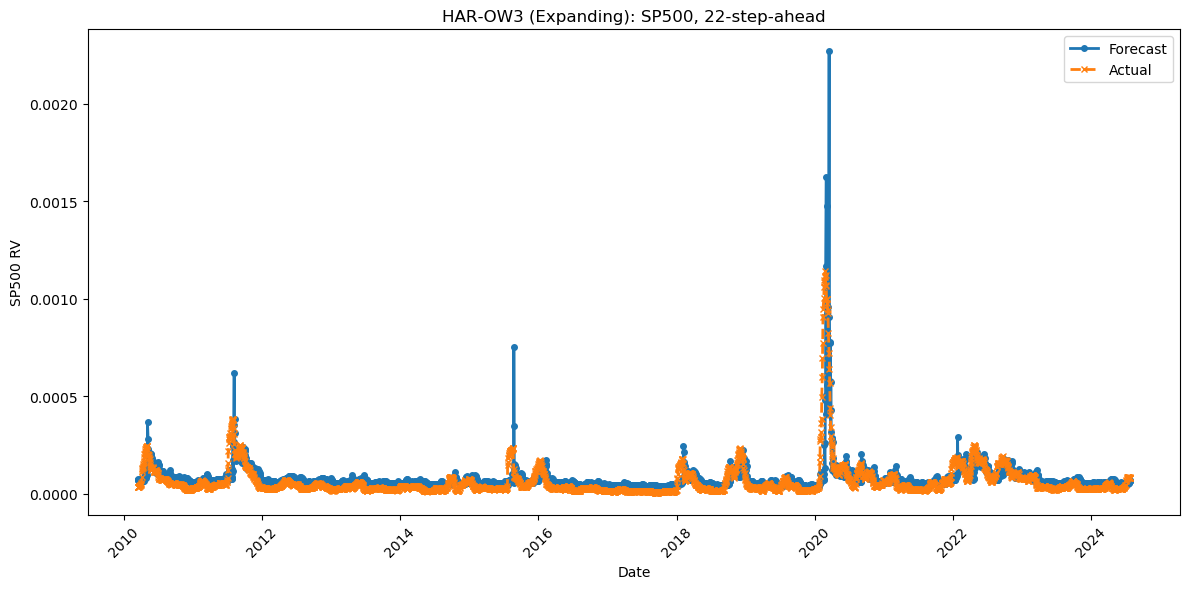

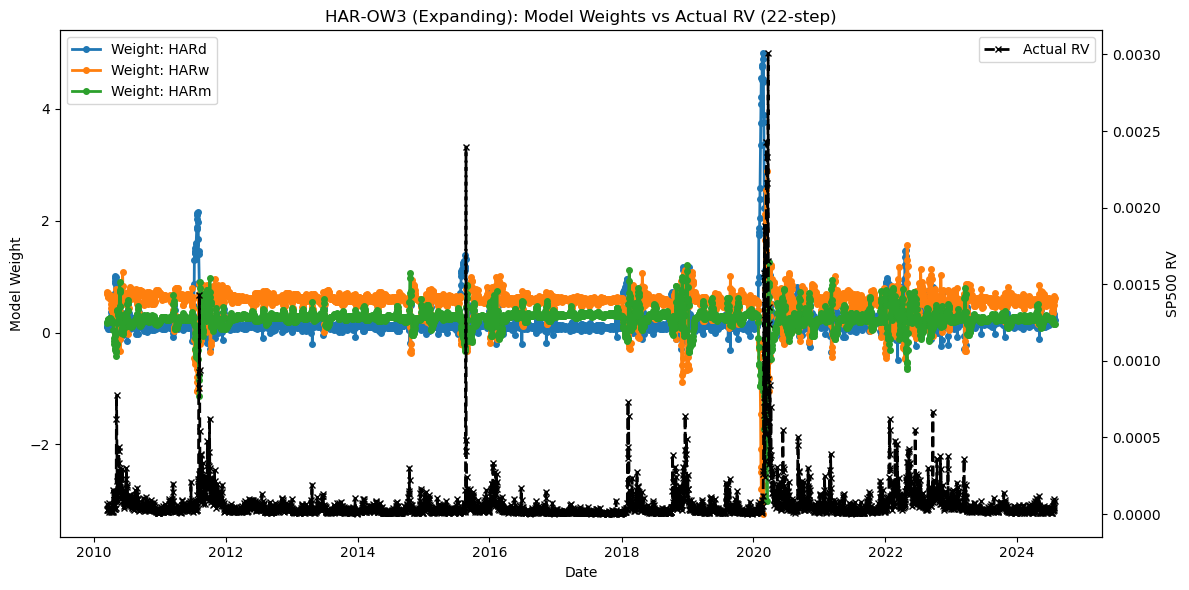

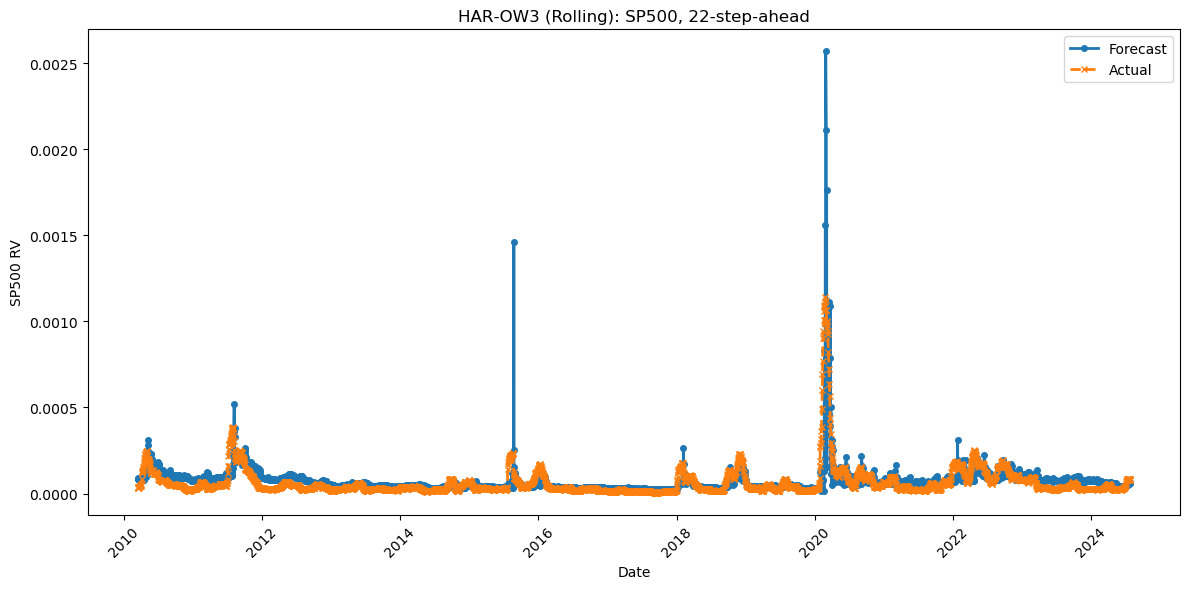

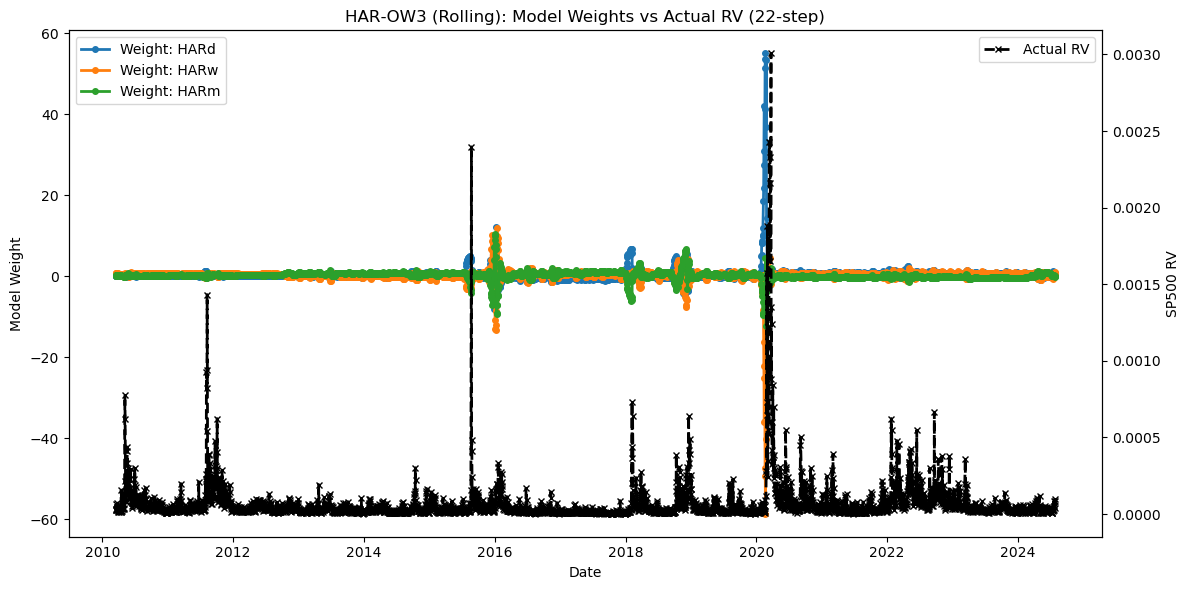

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

###############################################################################
# User Parameters
###############################################################################
index_to_plot = 'SP500'
horizon_to_plot = 22  # 22-step-ahead forecast

# Define coefficient keys for HAR (standard) and for HAR-COW/HAR-OW3.
# For HAR, the coefficients are stored with keys reflecting the lag variable names.
coeff_keys_har = [f'RV_daily_{index_to_plot}', f'RV_weekly_{index_to_plot}', f'RV_monthly_{index_to_plot}']
# For HAR-COW/HAR-OW3, we stored individual sub-model coefficients/weights under:
coeff_keys_cow = ['HARd', 'HARw', 'HARm']

###############################################################################
# 1. HAR Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    # Locate forecast_date in df
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    # Compute the actual average realized volatility over horizon_to_plot days
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} Realized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 2. HAR Expanding - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Expanding)'
results = results_har_expanding

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

# Collect actual RV on the same dates (or you can modify to a shifted window if desired)
for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Coeff: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 3. HAR Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('forecast', np.nan)
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 4. HAR Rolling - Coefficients vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR (Rolling)'
results = results_har_rolling

dates_coeff = []
coeff_series = {key: [] for key in coeff_keys_har}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('coefficients', {})
    dates_coeff.append(date_val)
    for key in coeff_keys_har:
        coeff_series[key].append(params.get(key, np.nan))

for d in dates_coeff:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_har:
    plt.plot(dates_coeff, coeff_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Coeff: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Coefficient Value')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Coefficients vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑COW Expanding - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑COW forecasts may be stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑COW Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Expanding)'
results = results_HAR_COW_expanding

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})  # Look for model_weights instead of coefficients
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Weight: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 7. HAR‑COW Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑COW Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑COW (Rolling)'
results = results_HAR_COW_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Weight: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 5. HAR‑OW3 Expanding - Forecast vs Actual
#    (You can change "5" and "6", "7", "8" to any numbering you prefer, 
#     here we continue the pattern for HAR-OW3)
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Expanding)'
results = results_HAR_OW3_expanding

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    # HAR‑OW3 forecasts may also be stored under 'combined_forecast'
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 6. HAR‑OW3 Expanding - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Expanding)'
results = results_HAR_OW3_expanding

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # HAR-OW3 uses 'model_weights' as well
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Weight: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 7. HAR‑OW3 Rolling - Forecast vs Actual
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Rolling)'
results = results_HAR_OW3_rolling

dates = []
preds = []
actuals = []

for entry in results['forecasts'][index_to_plot][horizon_to_plot]:
    forecast_date = entry['date']
    pred_value = entry.get('combined_forecast', entry.get('forecast', np.nan))
    idx_in_df = df.index[df['Date'] == forecast_date].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_value = df.iloc[i_df+1 : i_df+horizon_to_plot+1][f'{index_to_plot}_RV'].mean()
    dates.append(forecast_date)
    preds.append(pred_value)
    actuals.append(actual_value)

plt.plot(dates, preds, marker='o', linestyle='-', linewidth=2, markersize=4, label='Forecast')
plt.plot(dates, actuals, marker='x', linestyle='--', linewidth=2, markersize=4, label='Actual')
plt.title(f'{model_name}: {index_to_plot}, {horizon_to_plot}-step-ahead')
plt.xlabel('Date')
plt.ylabel(f'{index_to_plot} RV')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###############################################################################
# 8. HAR‑OW3 Rolling - Model Weights vs Actual RV
###############################################################################
plt.figure(figsize=(12, 6))
model_name = 'HAR‑OW3 (Rolling)'
results = results_HAR_OW3_rolling

dates_weights = []
weight_series = {key: [] for key in coeff_keys_cow}
dates_rv = []
actual_rv = []

for entry in results['coefficients'][index_to_plot][horizon_to_plot]:
    date_val = entry['date']
    # Look for model weights under the 'model_weights' key
    params = entry.get('model_weights', {})
    dates_weights.append(date_val)
    for key in coeff_keys_cow:
        weight_series[key].append(params.get(key, np.nan))

for d in dates_weights:
    idx_in_df = df.index[df['Date'] == d].tolist()
    if not idx_in_df:
        continue
    i_df = idx_in_df[0]
    actual_val = df.iloc[i_df][f'{index_to_plot}_RV']
    dates_rv.append(d)
    actual_rv.append(actual_val)

for key in coeff_keys_cow:
    plt.plot(dates_weights, weight_series[key], marker='o', linestyle='-', linewidth=2, markersize=4, label=f'Weight: {key}')

ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dates_rv, actual_rv, marker='x', linestyle='--', linewidth=2, markersize=4, color='black', label='Actual RV')

ax1.set_xlabel('Date')
ax1.set_ylabel('Model Weight')
ax2.set_ylabel(f'{index_to_plot} RV')
plt.title(f'{model_name}: Model Weights vs Actual RV ({horizon_to_plot}-step)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
